In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.stats import norm
import math
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import plotly.express as px

In [2]:
# dataframe for demand log
df_demand_log = pd.read_excel('FruitSoul Demand Log Fixed.xlsx')
df_demand_log['Demand Request Date'] = df_demand_log['Demand Request Date'].dt.date
df_demand_log['Earliest Delivery Date'] = df_demand_log['Earliest Delivery Date'].dt.date
df_demand_log['Preferred Delivery Date'] = df_demand_log['Preferred Delivery Date'].dt.date
df_demand_log['Latest Delivery Date'] = df_demand_log['Latest Delivery Date'].dt.date
df_demand_log['Earliest Delivery Date'] = pd.to_datetime(df_demand_log['Earliest Delivery Date'])
df_demand_log['Preferred Delivery Date'] = pd.to_datetime(df_demand_log['Preferred Delivery Date'])
df_demand_log['Latest Delivery Date'] = pd.to_datetime(df_demand_log['Latest Delivery Date'])
df_demand_log['Demand Request Date'] = pd.to_datetime(df_demand_log['Demand Request Date'])
df_demand_log.rename(columns={'Demand Request Date': 'demandRequest'}, inplace=True)
df_demand_log.rename(columns={'Jar Size  (vol. ounces)': 'jarSize'}, inplace=True)
df_demand_log.rename(columns={'Earliest Delivery Date': 'earliestDelivery'}, inplace=True)
df_demand_log.rename(columns={'Preferred Delivery Date': 'preferredDelivery'}, inplace=True)
df_demand_log.rename(columns={'Latest Delivery Date': 'latestDelivery'}, inplace=True)
df_demand_log

,DemandID,demandRequest,Mix,jarSize,State,Quantity,earliestDelivery,preferredDelivery,latestDelivery
0,1,2021-01-01,Apple-Mango,8,Maryland,1,2021-01-01,2021-01-04,2021-01-07
1,2,2021-01-01,Blueberry-Lemon,32,Kentucky,1,2021-01-04,2021-01-06,2021-01-09
2,3,2021-01-01,Orange-Passionfruit,16,Minnesota,1,2021-01-07,2021-01-10,2021-01-11
3,4,2021-01-01,Orange-Passionfruit,16,California,1,2021-01-07,2021-01-11,2021-01-14
4,5,2021-01-01,Orange-Passionfruit,32,Louisiana,1,2021-01-01,2021-01-04,2021-01-10
...,...,...,...,...,...,...,...,...,...
835374,835375,2023-12-31,Orange-Passionfruit,32,Arizona,1,2023-12-31,2024-01-05,2024-01-13
835375,835376,2023-12-31,Peach-Raspberry,32,California,1,2023-12-31,2024-01-01,2024-01-01
835376,835377,2023-12-31,Blueberry-Lemon,16,Arizona,1,2023-12-31,2024-01-02,2024-01-02
835377,835378,2023-12-31,Strawberry-Kiwi,8,California,1,2023-12-31,2024-01-03,2024-01-03


# Task 1

### Demand by Mix and Jar Size (with offset for clarity)

In [3]:
# Make a pivot table for over demand request date
pivot_demand_request_date_by_mix = df_demand_log.pivot_table(index='demandRequest', 
                                        columns=['Mix', 'jarSize'], 
                                        values='Quantity', aggfunc='sum', fill_value=0)

@interact
def interactive_plot(mix=pivot_demand_request_date_by_mix.columns.levels[0]):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Define colors for each jar size
    colors = ['blue', 'green', 'red']

    # Plot with vertical offsets and specified colors
    pivot_demand_request_date_by_mix[(mix, 8)].add(0).plot(ax=ax, label='8 oz', color=colors[0])
    pivot_demand_request_date_by_mix[(mix, 16)].add(50).plot(ax=ax, label='16 oz, 50 quantity offset', color=colors[1])
    pivot_demand_request_date_by_mix[(mix, 32)].add(100).plot(ax=ax, label='32 oz, 100 quantity offset', color=colors[2])

    # Add labels and title
    ax.set_xlabel('Demand Request Date')
    ax.set_ylabel('Quantity')
    ax.set_title(f'Daily Demand for {mix}')
    ax.legend()

    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

interactive(children=(Dropdown(description='mix', options=('Apple-Mango', 'Blueberry-Lemon', 'Cherry-Lime', 'G…

In general, 8oz products have the most demand, with 32oz being the next highest. The pineapple-coconut flavor has the least demand with orange-passionfruit having the most. The demand patterns look mostly the same, regardless of product type. Note that in all three years, the blackberry-pear flavor has never been ordered, hence no graph to show above.

### State Demand Histories

This shows the demand history in all 50 states.

In [4]:
# Create a pivot table indexed by demand request date with all states
pivot_demand_by_state = df_demand_log.pivot_table(index='demandRequest', 
                                                             columns='State', 
                                                             values='Quantity', 
                                                             aggfunc='sum', 
                                                             fill_value=0)

@interact
def plot_state_demand(state=pivot_demand_by_state.columns):
    fig, ax = plt.subplots(figsize=(12, 6))
    pivot_demand_by_state[state].plot(ax=ax, title=state)
    ax.set_xlabel('Demand Request Date')
    ax.set_ylabel('Quantity')
    plt.show()    

interactive(children=(Dropdown(description='state', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Cali…

Many states have nearly no demand, such as Wyoming and Vermont. As expected, the states with large populations have large demand, such as California, New York, and Texas.

### Total Demand History

These graphs show total demand per request date along with the yearly averages. Check the box to zoom to the lower quarter of the data.

In [5]:
# Make a pivot table for over demand request date
pivot_demand_request_date = df_demand_log.pivot_table(index='demandRequest', 
                                        values='Quantity', aggfunc='sum', fill_value=0)

# Calculate the average quantity for each year and match the last day
average_quantity_by_year = pivot_demand_request_date.resample('YE').mean()

# Refine average quantity by year to make a proper line plot
for i in average_quantity_by_year.index:
    year = pd.to_datetime(f'{i.year}-01-01')
    new_row = pd.DataFrame({'Quantity': [average_quantity_by_year.loc[i, 'Quantity']]}, index=[year])
    average_quantity_by_year = pd.concat([average_quantity_by_year, new_row]).sort_index()

# Create a list of yearly averages as strings
yearly_averages = [f'{i.year}: {average_quantity_by_year.loc[i, "Quantity"]:.2f}' for i in average_quantity_by_year.index]

# Remove duplicates in yearly_averages
yearly_averages = list(dict.fromkeys(yearly_averages))

def plot_with_zoom(zoom=False):
    plt.figure(figsize=(12, 6))
    plt.plot(pivot_demand_request_date.index, pivot_demand_request_date['Quantity'], label='Total Demand', linewidth=2, color='orange')
    plt.plot(average_quantity_by_year.index, average_quantity_by_year['Quantity'], label='Average by Year', color='b')

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.title('Total Demand Quantity and Yearly Averages Over Time')
    plt.legend()
    plt.legend(frameon=False)
    # Add yearly averages to the legend
    plt.text(0.06, 0.88, '\n'.join(yearly_averages), transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.0))

    if zoom:
        plt.ylim(0, pivot_demand_request_date['Quantity'].max() / 4)

    plt.show()

interact(plot_with_zoom, zoom=False)

interactive(children=(Checkbox(value=False, description='zoom'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_with_zoom(zoom=False)>

Clearly the promotion during cyberweek has a huge affect on demand, with each one making average yearly demand jump up by around 500 units.

### Demand History by Earliest, Preferred, and Latest Delivery Dates

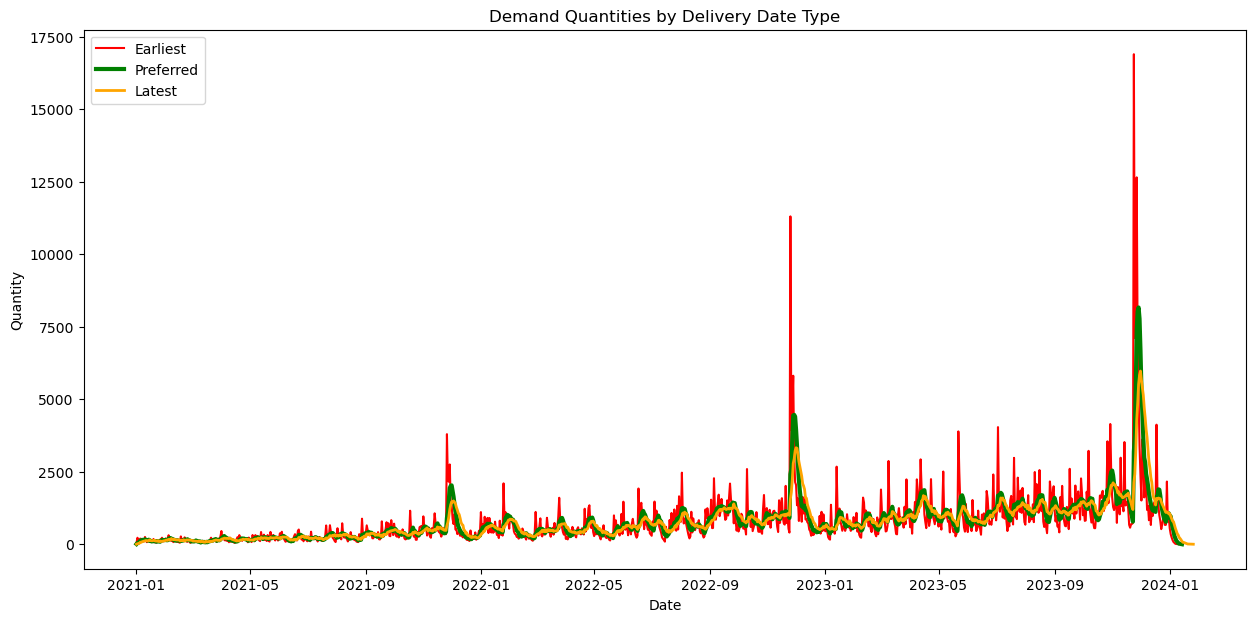

In [6]:
# Create a pivot table indexed by preferred delivery date
pivot_preferred_delivery_date = df_demand_log.pivot_table(index='preferredDelivery', 
                                                        values='Quantity',
                                                        aggfunc='sum', 
                                                        fill_value=0)

pivot_earliest_delivery_date = df_demand_log.pivot_table(index='earliestDelivery', 
                                                        values='Quantity',
                                                        aggfunc='sum', 
                                                        fill_value=0)

pivot_latest_delivery_date = df_demand_log.pivot_table(index='latestDelivery', 
                                                        values='Quantity',
                                                        aggfunc='sum', 
                                                        fill_value=0)

# Plot all three pivot tables on the same graph
plt.figure(figsize=(15, 7))
plt.plot(pivot_earliest_delivery_date.index, pivot_earliest_delivery_date['Quantity'], label='Earliest', color='r')
plt.plot(pivot_preferred_delivery_date.index, pivot_preferred_delivery_date['Quantity'], label='Preferred', linewidth=3, color="g")
plt.plot(pivot_latest_delivery_date.index, pivot_latest_delivery_date['Quantity'], label='Latest', linewidth=2, color='orange')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Demand Quantities by Delivery Date Type')
plt.legend()
plt.show()

If FruitSoul tries to meet demand by earliest date, they will have a hard time as it spikes in many places. Meeting demand via preferred, latest, or a (more realistically) blended approach will result in smoother operations.

### Smoothing Demand with Averages

We find the top 10 days with the most total demand request and average each request over their earliest and latest delivery days. This smooths the sharp peaks in a few places.

In [50]:
# The amount of demand request dates to smooth
x = 10

# Create a pivot table indexed by demand request date with columns for quantity and all three delivery dates
pivot_smoothed_demand = df_demand_log.pivot_table(index='demandRequest', values='Quantity', aggfunc='sum', fill_value=0)

pivot_smoothed_demand = pivot_smoothed_demand.astype({'Quantity': 'float'})

# Find the top x demand request dates with the highest quantity
top_demand_dates = pivot_smoothed_demand.nlargest(x, 'Quantity')

# Set the demandRequest dates from top_demand_dates to zero in pivot_smoothed_demand
pivot_smoothed_demand.loc[top_demand_dates.index, 'Quantity'] = 0

# Iterate over the top demand dates
for date, row in top_demand_dates.iterrows():
    
    # Filter the original dataframe for the current top demand date
    df_filtered = df_demand_log[df_demand_log['demandRequest'] == date]
    
    # Iterate over the filtered dataframe
    for _, demand_row in df_filtered.iterrows():
        # Calculate the date range from earliest to latest delivery
        date_range = pd.date_range(start=demand_row['earliestDelivery'], end=demand_row['latestDelivery'])
        
        # Calculate the daily quantity
        daily_quantity = demand_row['Quantity'] / len(date_range)
        
        # Add an entry into pivot_smoothed_demand for each date in date_range with quantity daily_quantity
        for single_date in date_range:
            if single_date in pivot_smoothed_demand.index:
                pivot_smoothed_demand.at[single_date, 'Quantity'] += daily_quantity
            else:
                pivot_smoothed_demand.at[single_date, 'Quantity'] = daily_quantity

pivot_smoothed_demand.sort_index(inplace=True)


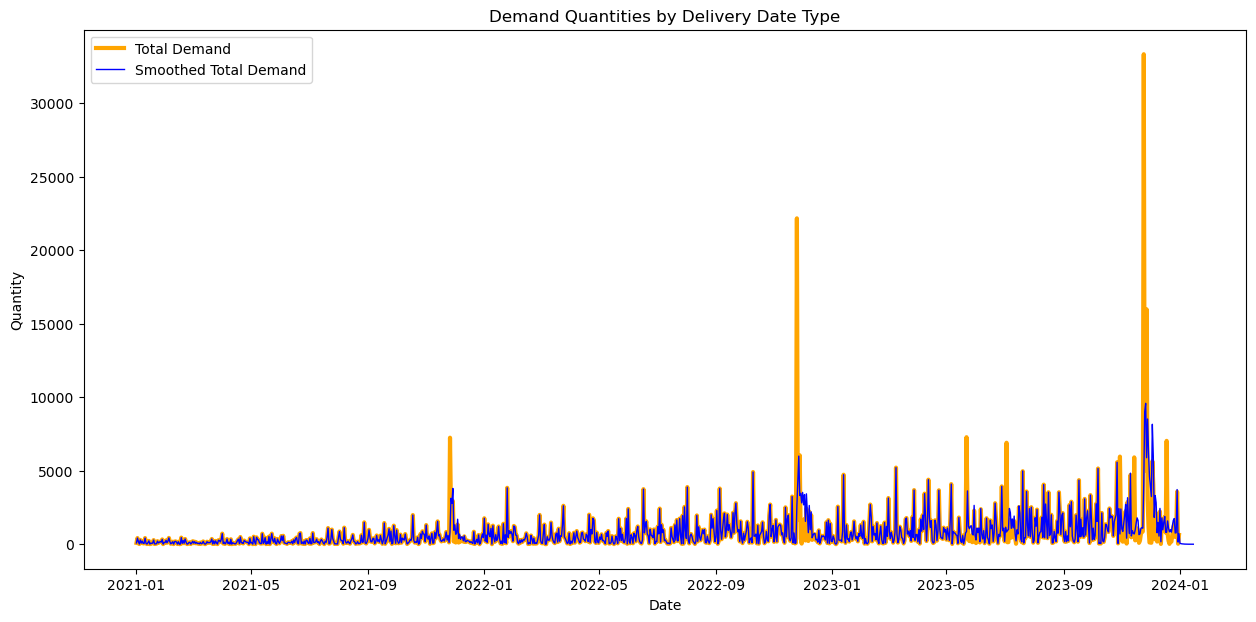

In [145]:
pivot_demand_request_date = df_demand_log.pivot_table(index='demandRequest', values='Quantity', aggfunc='sum', fill_value=0)

plt.figure(figsize=(15, 7))
plt.plot(pivot_demand_request_date.index, pivot_demand_request_date['Quantity'], label='Total Demand', linewidth=3, color='orange')
plt.plot(pivot_smoothed_demand.index, pivot_smoothed_demand['Quantity'], label='Smoothed Total Demand', linewidth=1, color='b')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Demand Quantities by Delivery Date Type')
plt.legend()
plt.show()

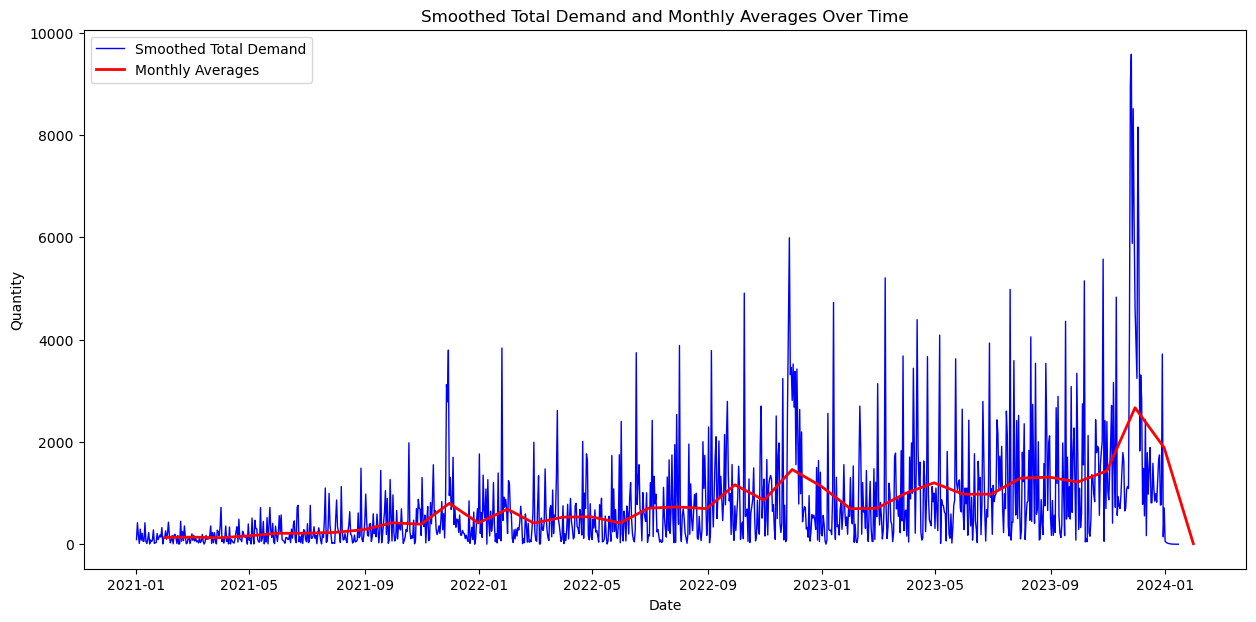

In [152]:
# Resample the pivot_smoothed_demand to quarterly frequency and calculate the mean
# Resample the pivot_smoothed_demand to weekly frequency and calculate the mean
monthly_averages_smoothed_demand = pivot_smoothed_demand.resample('ME').mean()

# Plot both the smoothed demand and the quarterly averages
plt.figure(figsize=(15, 7))
plt.plot(pivot_smoothed_demand.index, pivot_smoothed_demand['Quantity'], label='Smoothed Total Demand', linewidth=1, color='b')
plt.plot(monthly_averages_smoothed_demand.index, monthly_averages_smoothed_demand['Quantity'], label='Monthly Averages', linewidth=2, color='r')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Smoothed Total Demand and Monthly Averages Over Time')
plt.legend()
plt.show()

By spreading out some of the largest demand, it will be easier to handle orders in those peak seasons, namely Nov-Dec.

# Task 2

In [13]:
# Create a pivot table with references to plot later
pivot_demand_request_date = df_demand_log.pivot_table(index='demandRequest', values='Quantity', aggfunc='sum')
pivot_demand_request_date['Day of Week'] = pivot_demand_request_date.index.day_name()
pivot_demand_request_date['Week'] = (pivot_demand_request_date.index - pivot_demand_request_date.index.min()).days // 7 + 1
pivot_demand_request_date['Month'] = (pivot_demand_request_date.index.year - pivot_demand_request_date.index.min().year) * 12 + pivot_demand_request_date.index.month
pivot_demand_request_date['Quarter'] = (pivot_demand_request_date.index.year - pivot_demand_request_date.index.min().year) * 4 + pivot_demand_request_date.index.quarter
pivot_demand_request_date['Year'] = pivot_demand_request_date.index.year

,Quantity,Day of Week,Week,Month,Quarter,Year
demandRequest,,,,,,
2021-01-01,90,Friday,1,1,1,2021
2021-01-02,420,Saturday,1,1,1,2021
2021-01-03,178,Sunday,1,1,1,2021
2021-01-04,16,Monday,1,1,1,2021
2021-01-05,294,Tuesday,1,1,1,2021
...,...,...,...,...,...,...
2023-12-27,496,Wednesday,156,36,12,2023
2023-12-28,574,Thursday,156,36,12,2023
2023-12-29,3568,Friday,157,36,12,2023


In [8]:
# Find the top 20 demand request dates with the highest quantity
top_20_demand_dates = pivot_demand_request_date.nlargest(20, 'Quantity')
top_20_demand_dates

,Quantity,Day of Week
demandRequest,,
2023-11-24,33324,Friday
2022-11-25,22162,Friday
2023-11-27,15975,Monday
2023-05-22,7279,Monday
2021-11-26,7244,Friday
2023-12-18,7030,Monday
2023-07-03,6902,Monday
2022-11-28,6048,Monday
2023-10-30,5959,Monday


This shows that the November Cyber Week promotion brings in a lot of demand. They must also have a promotion around May, and possibly July.

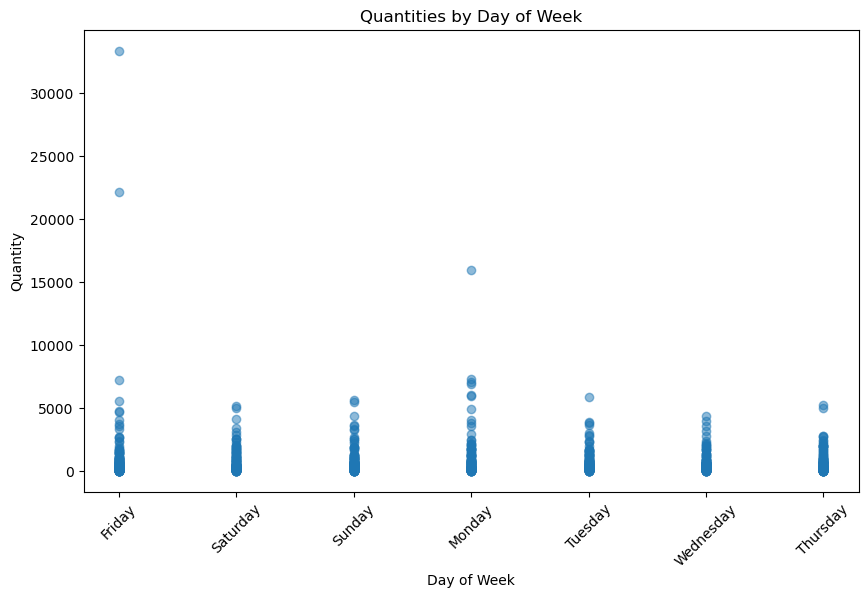

In [9]:
# Plot the days of week with their quantities on a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pivot_demand_request_date['Day of Week'], pivot_demand_request_date['Quantity'], alpha=0.5)
plt.title('Quantities by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
#plt.grid(True)
plt.show()

Here we see the day of week seasonality. Friday and Monday have the most.

In [10]:
pivot_demand_request_date_copy = pivot_demand_request_date.copy()
# Set the highest three values for pivot_demand_request_date_copy to have quantities equal to 7200, approximately the fourth highest value
pivot_demand_request_date_copy.loc[pivot_demand_request_date_copy['Quantity'].nlargest(3).index, 'Quantity'] = 7200
pivot_avg_quantity_by_day_of_week = pivot_demand_request_date_copy.pivot_table(index='Day of Week', values='Quantity', aggfunc='mean')
pivot_avg_quantity_by_day_of_week

,Quantity
Day of Week,
Friday,871.566879
Monday,911.807692
Saturday,726.820513
Sunday,716.847134
Thursday,646.641026
Tuesday,702.333333
Wednesday,605.245161


Replacing the three from the dotplot above with similar quantities and finding the average of all days of the week, it's clear Friday and Monday have the most demand and Wednesday and Thursday have the least. 

In [14]:
@interact
def plot_demand_by_time(index=['Week', 'Month', 'Quarter', 'Year']):
    pivot_demand_by_time = pivot_demand_request_date.pivot_table(index=index, values='Quantity', aggfunc='sum')
    pivot_demand_by_time.plot(kind='bar', figsize=(12, 6))
    plt.title(f'Total Quantity by {index}')
    plt.xlabel(index)
    plt.ylabel('Total Quantity')
    plt.xticks(ticks=range(0, len(pivot_demand_by_time), 5), labels=range(1, len(pivot_demand_by_time) + 1, 5), rotation=45)
    plt.show()

interactive(children=(Dropdown(description='index', options=('Week', 'Month', 'Quarter', 'Year'), value='Week'…

Besides the obvious spike in November in all years, there is a drop-rise in February-March and May-June for 2022 and February-March and June-July in 2023.

# Task 3

In [15]:
# Create a pivot table with index 'Demand Request Date' and columns 'Mix' and 'jarSize'
pivot_product_quantities_shares = df_demand_log.pivot_table(index='demandRequest',
                                                     columns=['Mix', 'jarSize'],
                                                     values='Quantity', aggfunc='sum', fill_value=0)

# Normalize the quantities to be the percentage of total quantity among each row
pivot_product_quantities_shares = pivot_product_quantities_shares.div(pivot_product_quantities_shares.sum(axis=1), axis=0) * 100

# Create a pivot table with index 'demandRequest' and columns 'Mix'
pivot_mixes_shares = pivot_product_quantities_shares.T.groupby(level=0).sum().T

@interact
def plot_mix_shares(mix=pivot_mixes_shares.columns):
    fig, ax = plt.subplots(figsize=(14, 7))
    pivot_mixes_shares[mix].plot(ax=ax)
    ax.set_title(f'Demand Share for {mix} Over Time')
    ax.set_xlabel('demandRequest')
    ax.set_ylabel('Demand Share (%)')
    plt.show()

interactive(children=(Dropdown(description='mix', options=('Apple-Mango', 'Blueberry-Lemon', 'Cherry-Lime', 'G…

In [18]:
# Create a pivot table with index 'demandRequest' and columns 'jarSize'
pivot_jar_sizes_shares = pivot_product_quantities_shares.T.groupby(level=1).sum().T

@interact
def plot_jar_sizes(oz_8=True, oz_16=True, oz_32=True):
    fig, ax = plt.subplots(figsize=(14, 7))
    
    if oz_8:
        pivot_jar_sizes_shares[8].plot(ax=ax, label='8 oz', color='blue')
    if oz_16:
        pivot_jar_sizes_shares[16].plot(ax=ax, label='16 oz', color='orange')
    if oz_32:
        pivot_jar_sizes_shares[32].plot(ax=ax, label='32 oz', color='green')
    
    ax.set_title('Demand Share by Jar Size Over Time')
    ax.set_xlabel('Demand Request Date')
    ax.set_ylabel('Demand Share (%)')
    ax.set_ylim(0, 100)
    ax.legend(title='Jar Size (vol. ounces)')
    plt.show()

interactive(children=(Checkbox(value=True, description='oz_8'), Checkbox(value=True, description='oz_16'), Che…

There is a lot of fluctuations in these graphs. Below are the quarterly averages to see trends more clearly.

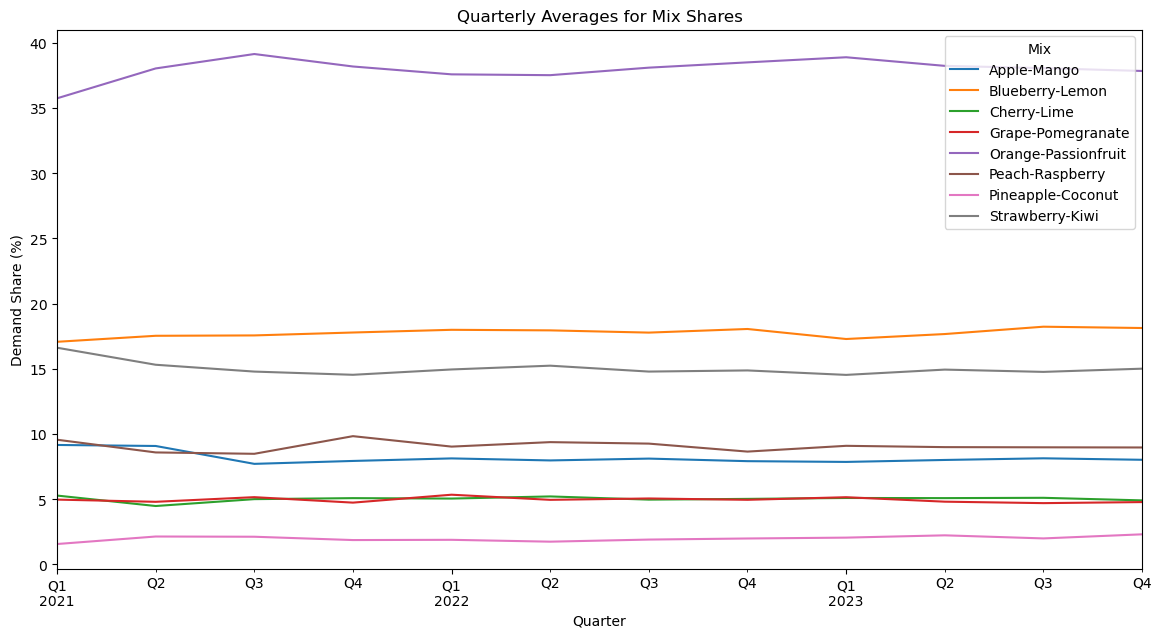

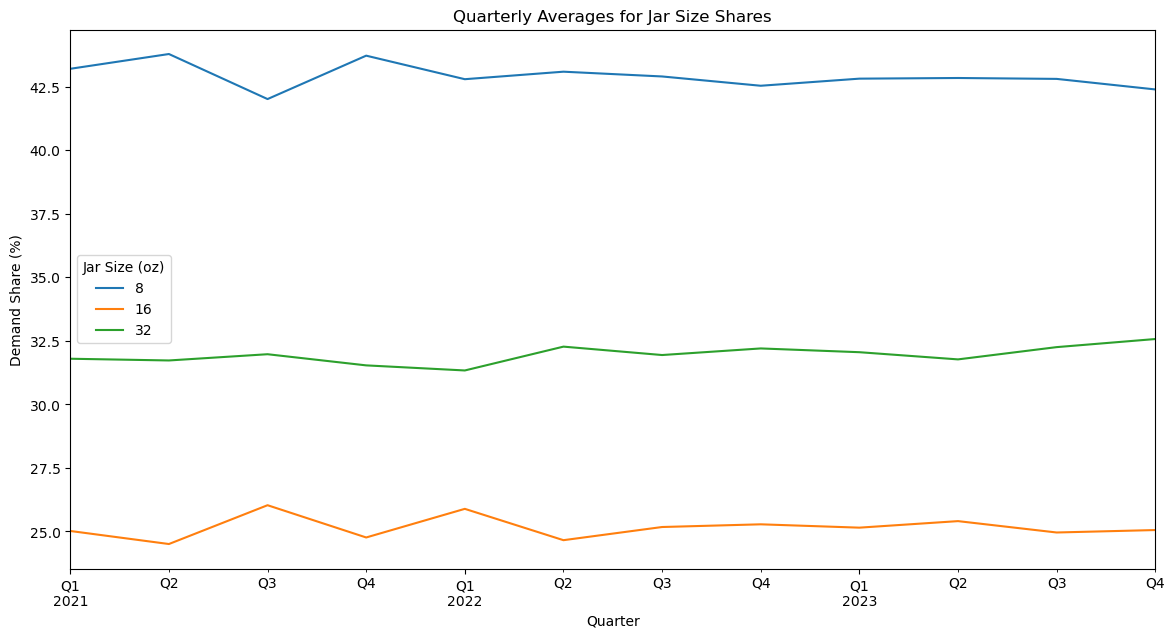

In [53]:
# Resample the pivot table to quarterly frequency and calculate the mean for each mix
quarterly_averages_mix_shares = pivot_mixes_shares.resample('QE').mean()

# Plot the quarterly averages for mix shares
quarterly_averages_mix_shares.plot(kind='line', figsize=(14, 7))
plt.title('Quarterly Averages for Mix Shares')
plt.xlabel('Quarter')
plt.ylabel('Demand Share (%)')
plt.legend(title='Mix')
plt.show()

# Resample the pivot table to quarterly frequency and calculate the mean for each jar size
quarterly_averages = pivot_jar_sizes_shares.resample('QE').mean()
quarterly_averages.plot(kind='line', figsize=(14, 7))
plt.title('Quarterly Averages for Jar Size Shares')
plt.xlabel('Quarter')
plt.ylabel('Demand Share (%)')
plt.legend(title='Jar Size (oz)')
plt.show()

The obvious winner is Orange-Passionfruit for mixes and the 8oz jar size for demand share. Both graphs tend to have a bit more fluctuation in 2021, but all are mostly constant in average through the three years.

# Task 4

These graphs show the total demand share by state.

In [19]:
pivot_state_demand = df_demand_log.pivot_table(index='demandRequest', columns='State', values='Quantity', aggfunc='sum', fill_value=0)
pivot_state_demand_share = pivot_state_demand.div(pivot_state_demand.sum(axis=1), axis=0) * 100

In [20]:
@interact
def plot_state_demand_interactive(state=pivot_state_demand_share.columns):
    fig, ax = plt.subplots(figsize=(12, 6))
    pivot_state_demand_share[state].plot(ax=ax, title=state)
    ax.set_xlabel('Demand Request Date')
    ax.set_ylabel('Demand Share (%)')
    plt.show()

interactive(children=(Dropdown(description='state', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Cali…

Show yearly (quarterly) averages as a table? Show percentage change?

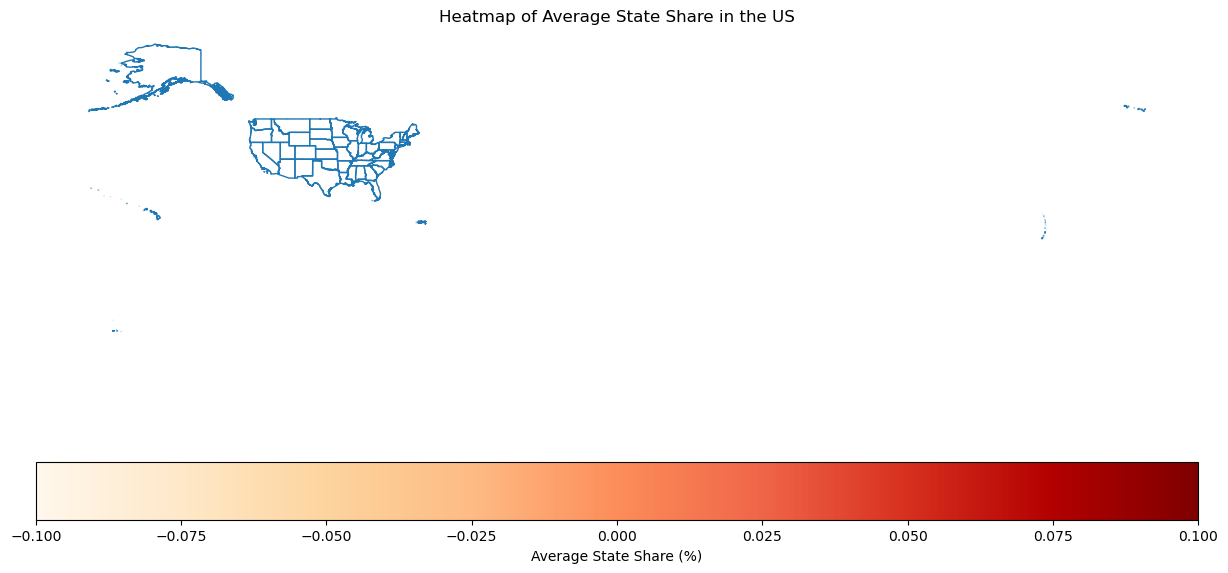

In [35]:
# Merge the average state share with the states GeoDataFrame
states['average_share'] = states['STUSPS'].map(average_state_share)

# Plot the heatmap
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
states.boundary.plot(ax=ax, linewidth=1)
states.plot(column='average_share', ax=ax, legend=True,
            legend_kwds={'label': "Average State Share (%)",
                         'orientation': "horizontal"},
            cmap='OrRd')

# Set the title
ax.set_title('Heatmap of Average State Share in the US')

# Remove axis for better visualization
ax.set_axis_off()

plt.show()

In [34]:
# Calculate the average share for each state from pivot_state_demand_share
average_state_share = pivot_state_demand_share.mean()

# Display the average share for each state
average_state_share

State
Alabama            1.101864
Alaska             0.243392
Arizona            1.788132
Arkansas           0.618772
California        14.607095
Colorado           1.884339
Connecticut        1.471598
Delaware           0.372898
Florida            5.237364
Georgia            2.843000
Hawaii             0.422487
Idaho              0.383430
Illinois           4.210599
Indiana            1.905841
Iowa               0.876579
Kansas             0.774585
Kentucky           1.069415
Louisiana          1.268720
Maine              0.303864
Maryland           2.041946
Massachusetts      2.801346
Michigan           2.502033
Minnesota          1.754945
Mississippi        0.545747
Missouri           1.599591
Montana            0.255068
Nebraska           0.637741
Nevada             0.777336
New Hampshire      0.476340
New Jersey         3.013663
New Mexico         0.509291
New York           8.308217
North Carolina     2.779996
North Dakota       0.271194
Ohio               3.169945
Oklahoma      

In [17]:
# Resample the pivot table to quarterly frequency and calculate the mean for each state
yearly_average_state_shares = pivot_state_demand_share.resample('YE').mean()

# Display the quarterly averages
yearly_average_state_shares

State,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
demandRequest,,,,,,,,,,,,,,,,,,,,,
2021-12-31,1.218256,0.227975,1.780983,0.571851,14.407686,1.943325,1.616257,0.355080,5.270714,2.803227,...,0.226571,1.842683,9.067207,0.841319,0.124703,2.524406,2.826926,0.362359,1.694097,0.231104
2022-12-31,1.050781,0.258715,1.798182,0.599834,14.707131,1.844897,1.410152,0.374553,5.303947,2.849872,...,0.265147,1.958069,8.789878,0.921516,0.169789,2.521281,2.982168,0.337334,1.644425,0.166139
2023-12-31,1.037194,0.243400,1.785192,0.684375,14.705375,1.865119,1.389178,0.388964,5.137614,2.875683,...,0.255816,1.864740,8.668715,0.976541,0.173958,2.601533,3.024238,0.345466,1.655348,0.192654


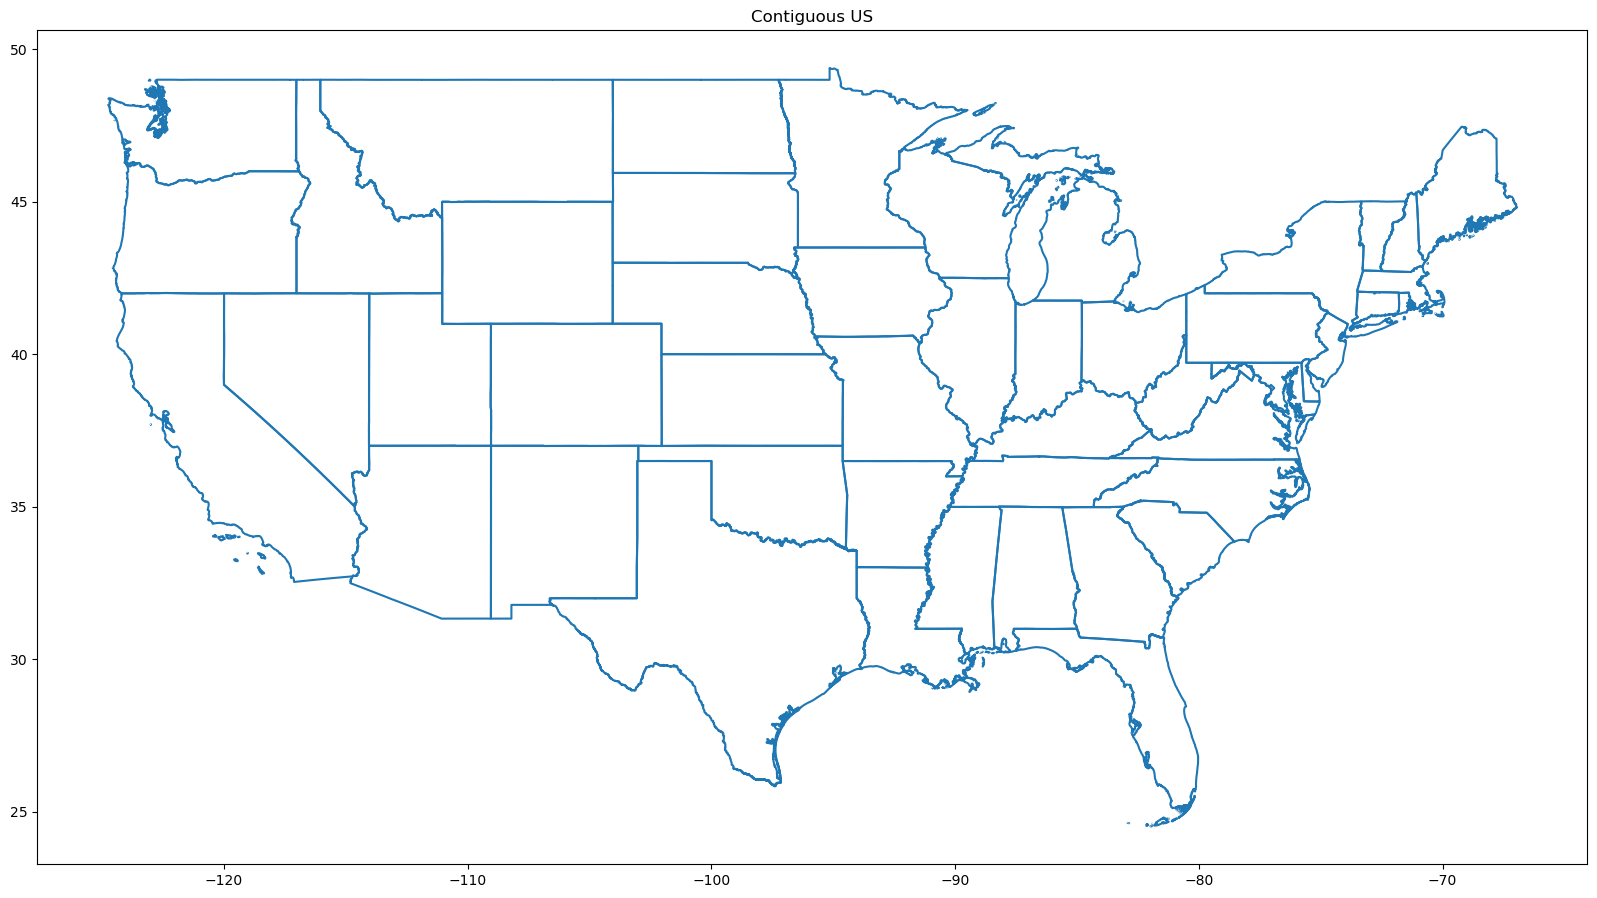

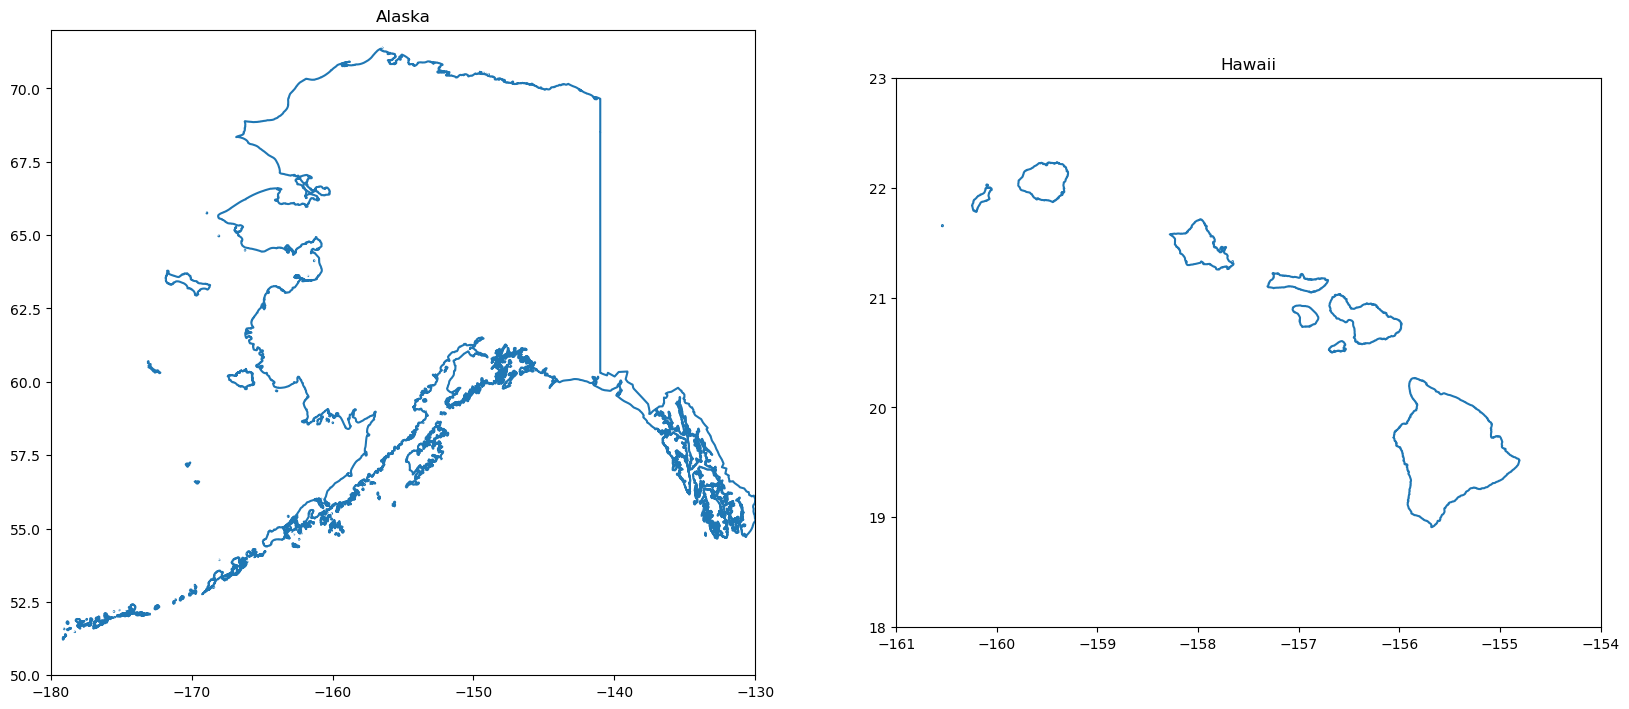

In [32]:
states = gpd.read_file('cb_2023_us_state_500k.shp')



states_to_plot = states[~states['STUSPS'].isin(['AK', 'HI', 'PR', 'DC', 'VI', 'GU', 'AS', 'MP'])]

# Filter out Alaska and Hawaii for separate subplots
alaska = states[states['STUSPS'] == 'AK']
hawaii = states[states['STUSPS'] == 'HI']

fig, ax0 = plt.subplots(figsize=(20, 15))

fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the contiguous US states
states_to_plot.boundary.plot(ax=ax0)
ax0.set_title('Contiguous US')

# Plot Alaska with adjusted x and y limits to focus on the main state portion
alaska.boundary.plot(ax=ax2)
ax2.set_title('Alaska')
ax2.set_xlim(-180, -130)
ax2.set_ylim(50, 72)

# Plot Hawaii with adjusted x and y limits to focus on the main state portion
hawaii.boundary.plot(ax=ax1)
ax1.set_title('Hawaii')
ax1.set_xlim(-161, -154)
ax1.set_ylim(18, 23)

plt.show()

# Task 5

In [23]:
df_delivery_costs_and_times = pd.read_excel('FruitSoul Expected Delivery Costs and Times.xlsx')

### Add acceptable shipping date columns. Make sure they do not land on holidays or Sundays.

In [24]:
# Add shipping date columns
# Merge df_demand_log with df_delivery_costs_and_times to get the delivery times for each state
df_merged = df_demand_log.merge(df_delivery_costs_and_times, left_on='State', right_on='Destination State')

# Calculate the new shipping dates
df_merged['earliestShipping'] = df_merged['earliestDelivery'] - pd.to_timedelta(df_merged['Expected                     Delivery Time     From Stone Mountain (days)'], unit='d')
df_merged['preferredShipping'] = df_merged['preferredDelivery'] - pd.to_timedelta(df_merged['Expected                     Delivery Time     From Stone Mountain (days)'], unit='d')
df_merged['latestShipping'] = df_merged['latestDelivery'] - pd.to_timedelta(df_merged['Expected                     Delivery Time     From Stone Mountain (days)'], unit='d')

# If the shipping date columns are not already datetime, also ensure they are converted
df_merged['earliestShipping'] = pd.to_datetime(df_merged['earliestShipping'])
df_merged['preferredShipping'] = pd.to_datetime(df_merged['preferredShipping'])
df_merged['latestShipping'] = pd.to_datetime(df_merged['latestShipping'])

# Function to check if a date is Labor Day
def is_labor_day(date):
    if date.strftime('%m') == '09' and date.strftime('%d') <= '07' and date.weekday() == 0:
        return True
    return False

# Define the date for the 4th of July 
july_4th = '07-04'

# Function to adjust dates for earliest or latest shipping dates on Sundays, labor days, or 4th of July
def adjust_date(date, type='e'):
    """
    Adjust the date based on the type:
    'e' for Earliest Acceptable Shipping Date,
    'l' for Latest Acceptable Shipping Date
    """
    if type == 'e':
        if date.weekday() == 6:
            date = date + pd.Timedelta(days=1)
        if is_labor_day(date) or date.strftime('%m-%d') == july_4th:
            date = date + pd.Timedelta(days=1)
            if date.weekday() == 6:
                date = date + pd.Timedelta(days=1)
        return date
    
    if type == 'l':
        if is_labor_day(date) or date.strftime('%m-%d') == july_4th:
            date = date - pd.Timedelta(days=1)
        if date.weekday() == 6:
            date = date - pd.Timedelta(days=1)
            if date.strftime('%m-%d') == july_4th:
                date = date - pd.Timedelta(days=1)
        return date

    return date

# Adjust the dates
df_merged['earliestShipping'] = df_merged['earliestShipping'].apply(lambda x: adjust_date(x, 'e'))
df_merged['latestShipping'] = df_merged['latestShipping'].apply(lambda x: adjust_date(x, 'l'))

# Function to check if a date is a Sunday, Labor Day, or the 4th of July
def is_special_day(date):
    return date.weekday() == 6 or is_labor_day(date) or date.strftime('%m-%d') == july_4th

# This function moves the preferred shipping date to the next day if it falls on a Sunday, Labor Day, or the 4th of July, afterward 
# checking if the new date is also a special day. If so, move it two days backwards, which cannot be a special day.
def adjust_preferred_shipping_date(date):
    if is_special_day(date):
        date += pd.Timedelta(days=1)
        if is_special_day(date):
            date -= pd.Timedelta(days=2)
    return date

# Adjust Preferred Shipping Date to earliest or latest if it is before or after the acceptable range
df_merged['preferredShipping'] = df_merged.apply(
    lambda row: row['earliestShipping'] if row['preferredShipping'] < row['earliestShipping'] else (
        row['latestShipping'] if row['preferredShipping'] > row['latestShipping'] else row['preferredShipping']
    ), axis=1
)

# Apply the function to the Preferred Shipping Date column
df_merged['preferredShipping'] = df_merged['preferredShipping'].apply(adjust_preferred_shipping_date)

Due to holidays, some demand is no longer feasible (shown below).

In [25]:
# Find the indexes where the 'Earliest Acceptable Shipping Date' is later than the 'Latest Acceptable Shipping Date'
invalid_shipping_dates = df_merged[df_merged['earliestShipping'] > df_merged['latestShipping']].index

# Display the count of such indexes
invalid_shipping_dates_count = len(invalid_shipping_dates)
print(f"Number of indexes with invalid shipping dates: {invalid_shipping_dates_count}")

Number of indexes with invalid shipping dates: 7273


This code double checks all holidays have been avoided.

In [26]:
# Dates for Labor Days
labor_days = ['2021-09-06', '2022-09-05', '2023-09-04']

# Filter the dataframe for entries where any of the shipping dates fall on Labor Days
labor_day_orders = df_merged[
    (df_merged['earliestShipping'].dt.strftime('%Y-%m-%d').isin(labor_days)) |
    (df_merged['preferredShipping'].dt.strftime('%Y-%m-%d').isin(labor_days)) |
    (df_merged['latestShipping'].dt.strftime('%Y-%m-%d').isin(labor_days))
]

# Display the count of such entries
labor_day_orders_count = labor_day_orders.shape[0]
print(f"Number of orders with shipping dates on Labor Days: {labor_day_orders_count}")

# Filter the dataframe for entries where any of the shipping dates fall on a Sunday
sunday_orders = df_merged[
    (df_merged['earliestShipping'].dt.weekday == 6) |
    (df_merged['preferredShipping'].dt.weekday == 6) |
    (df_merged['latestShipping'].dt.weekday == 6)
]

# Display the count of such entries
sunday_orders_count = sunday_orders.shape[0]
print(f"Number of orders with shipping dates on Sundays: {sunday_orders_count}")

# Filter the dataframe for entries where any of the shipping dates fall on the 4th of July
july_4th_orders = df_merged[
    (df_merged['earliestShipping'].dt.strftime('%m-%d') == july_4th) |
    (df_merged['preferredShipping'].dt.strftime('%m-%d') == july_4th) |
    (df_merged['latestShipping'].dt.strftime('%m-%d') == july_4th)
]

# Display the count of such entries
july_4th_orders_count = july_4th_orders.shape[0]
print(f"Number of orders with shipping dates on the 4th of July: {july_4th_orders_count}")

Number of orders with shipping dates on Labor Days: 0
Number of orders with shipping dates on Sundays: 0
Number of orders with shipping dates on the 4th of July: 0


Merge acceptable shipping dates with df_demand_log.

In [27]:
# Drop the extra columns from the merge with main dataframe
df_demand_log = df_merged.drop(columns=['Destination State', 'Approximate distance from Stone Mountain (miles)', 'Expected Delivery Cost From Stone Mountain (USD/ounce)', 'Expected                     Delivery Time     From Stone Mountain (days)'])

### Add minimal, preferred, and maximal order-to-ship dates.

In [28]:
# Calculate the order-to-ship times
df_demand_log['minOrderToShip'] = (df_demand_log['earliestShipping'] - df_demand_log['demandRequest']).dt.days
df_demand_log['preferredOrderToShip'] = (df_demand_log['preferredShipping'] - df_demand_log['demandRequest']).dt.days
df_demand_log['maxOrderToShip'] = (df_demand_log['latestShipping'] - df_demand_log['demandRequest']).dt.days

### Using a normal distribution to smooth demand.

In [34]:
# Function to compute demand probabilities based on a normal distribution
def demand_probability(row):
    preferred_date = row['preferredShipping']
    earliest_date = row['earliestShipping']
    latest_date = row['latestShipping']
    
    # Calculate the standard deviation (earliest/latest represent ±2 standard deviations)
    std_dev = (latest_date - earliest_date).days / 4
    
    # Ensure std_dev is at least 1 to avoid division by zero
    std_dev = max(std_dev, 1)
    
    # Initialize empty list for smoothed demand distribution
    demand_distribution = []
    
    # Compute cumulative probabilities for the range of acceptable shipping dates
    for day in pd.date_range(earliest_date, latest_date):
        # CDF at the start and end of the day
        cdf_start = norm.cdf((day - pd.Timedelta(days=0.5) - preferred_date).days, scale=std_dev)
        cdf_end = norm.cdf((day + pd.Timedelta(days=0.5) - preferred_date).days, scale=std_dev)
        
        # Cumulative probability for the 24-hour period (between start and end of the day)
        daily_probability = cdf_end - cdf_start
        
        demand_distribution.append({
            'Date': day,
            'Mix': row['Mix'],
            'Probability': daily_probability
        })
    
    # Convert list to DataFrame
    df_demand_distribution = pd.DataFrame(demand_distribution)

    if len(df_demand_distribution) == 0:
        return pd.DataFrame(columns=['Date', 'Mix', 'Smoothed Daily Demand'])
    
    # Normalize probabilities to sum up to 1, then scale to match total quantity
    total_probability = df_demand_distribution['Probability'].sum()
    df_demand_distribution['Smoothed Daily Demand'] = (df_demand_distribution['Probability'] / total_probability) * row['Quantity']
    
    return df_demand_distribution[['Date', 'Mix', 'Smoothed Daily Demand']]

Note: the code below take a long time to run.

In [35]:
# Apply the function to each row in the demand log and concatenate the results
smoothed_demand_history = pd.concat([demand_probability(row) for _, row in df_demand_log.iterrows()])

# Aggregate smoothed demand over date ranges
final_smoothed_demand_history = smoothed_demand_history.groupby(['Date', 'Mix']).agg({'Smoothed Daily Demand': 'sum'}).reset_index()

C:\Users\natej\AppData\Local\Temp\ipykernel_22136\114796216.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  smoothed_demand_history = pd.concat([demand_probability(row) for _, row in df_demand_log.iterrows()])


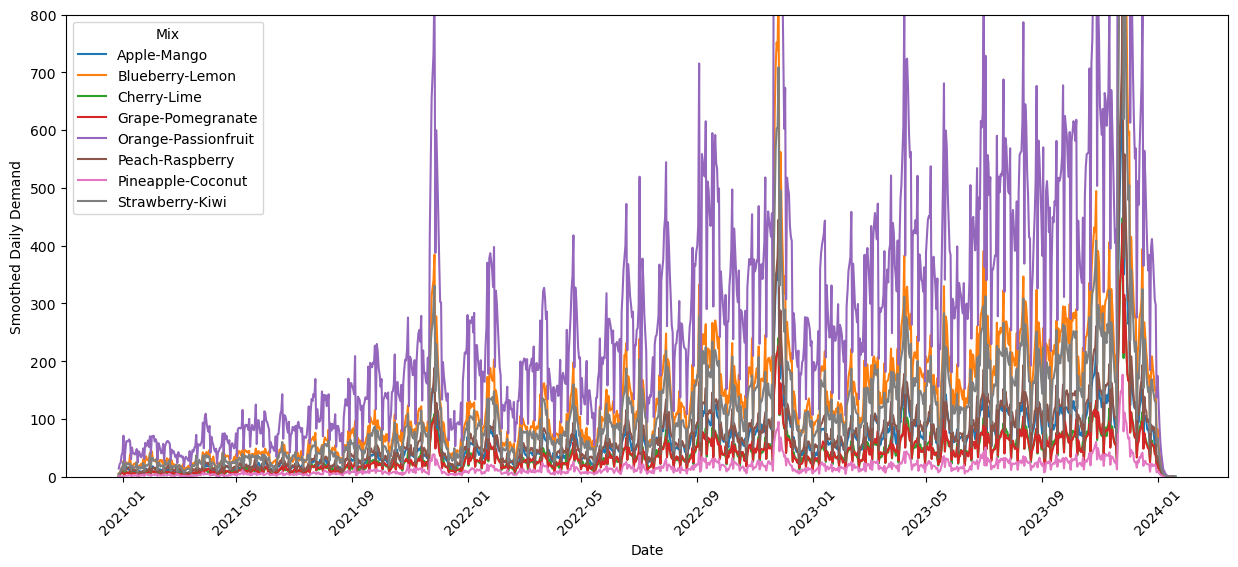

In [36]:
# Group by Mix and plot the smoothed daily demand over time
plt.figure(figsize=(15, 6))
for mix, group in final_smoothed_demand_history.groupby('Mix'):
    plt.plot(group['Date'], group['Smoothed Daily Demand'], label=mix)

plt.xlabel('Date')
plt.ylabel('Smoothed Daily Demand')
plt.legend(title='Mix', loc='upper left')
plt.xticks(rotation=45)
plt.ylim(0, 800)

# Display the plot
plt.show()

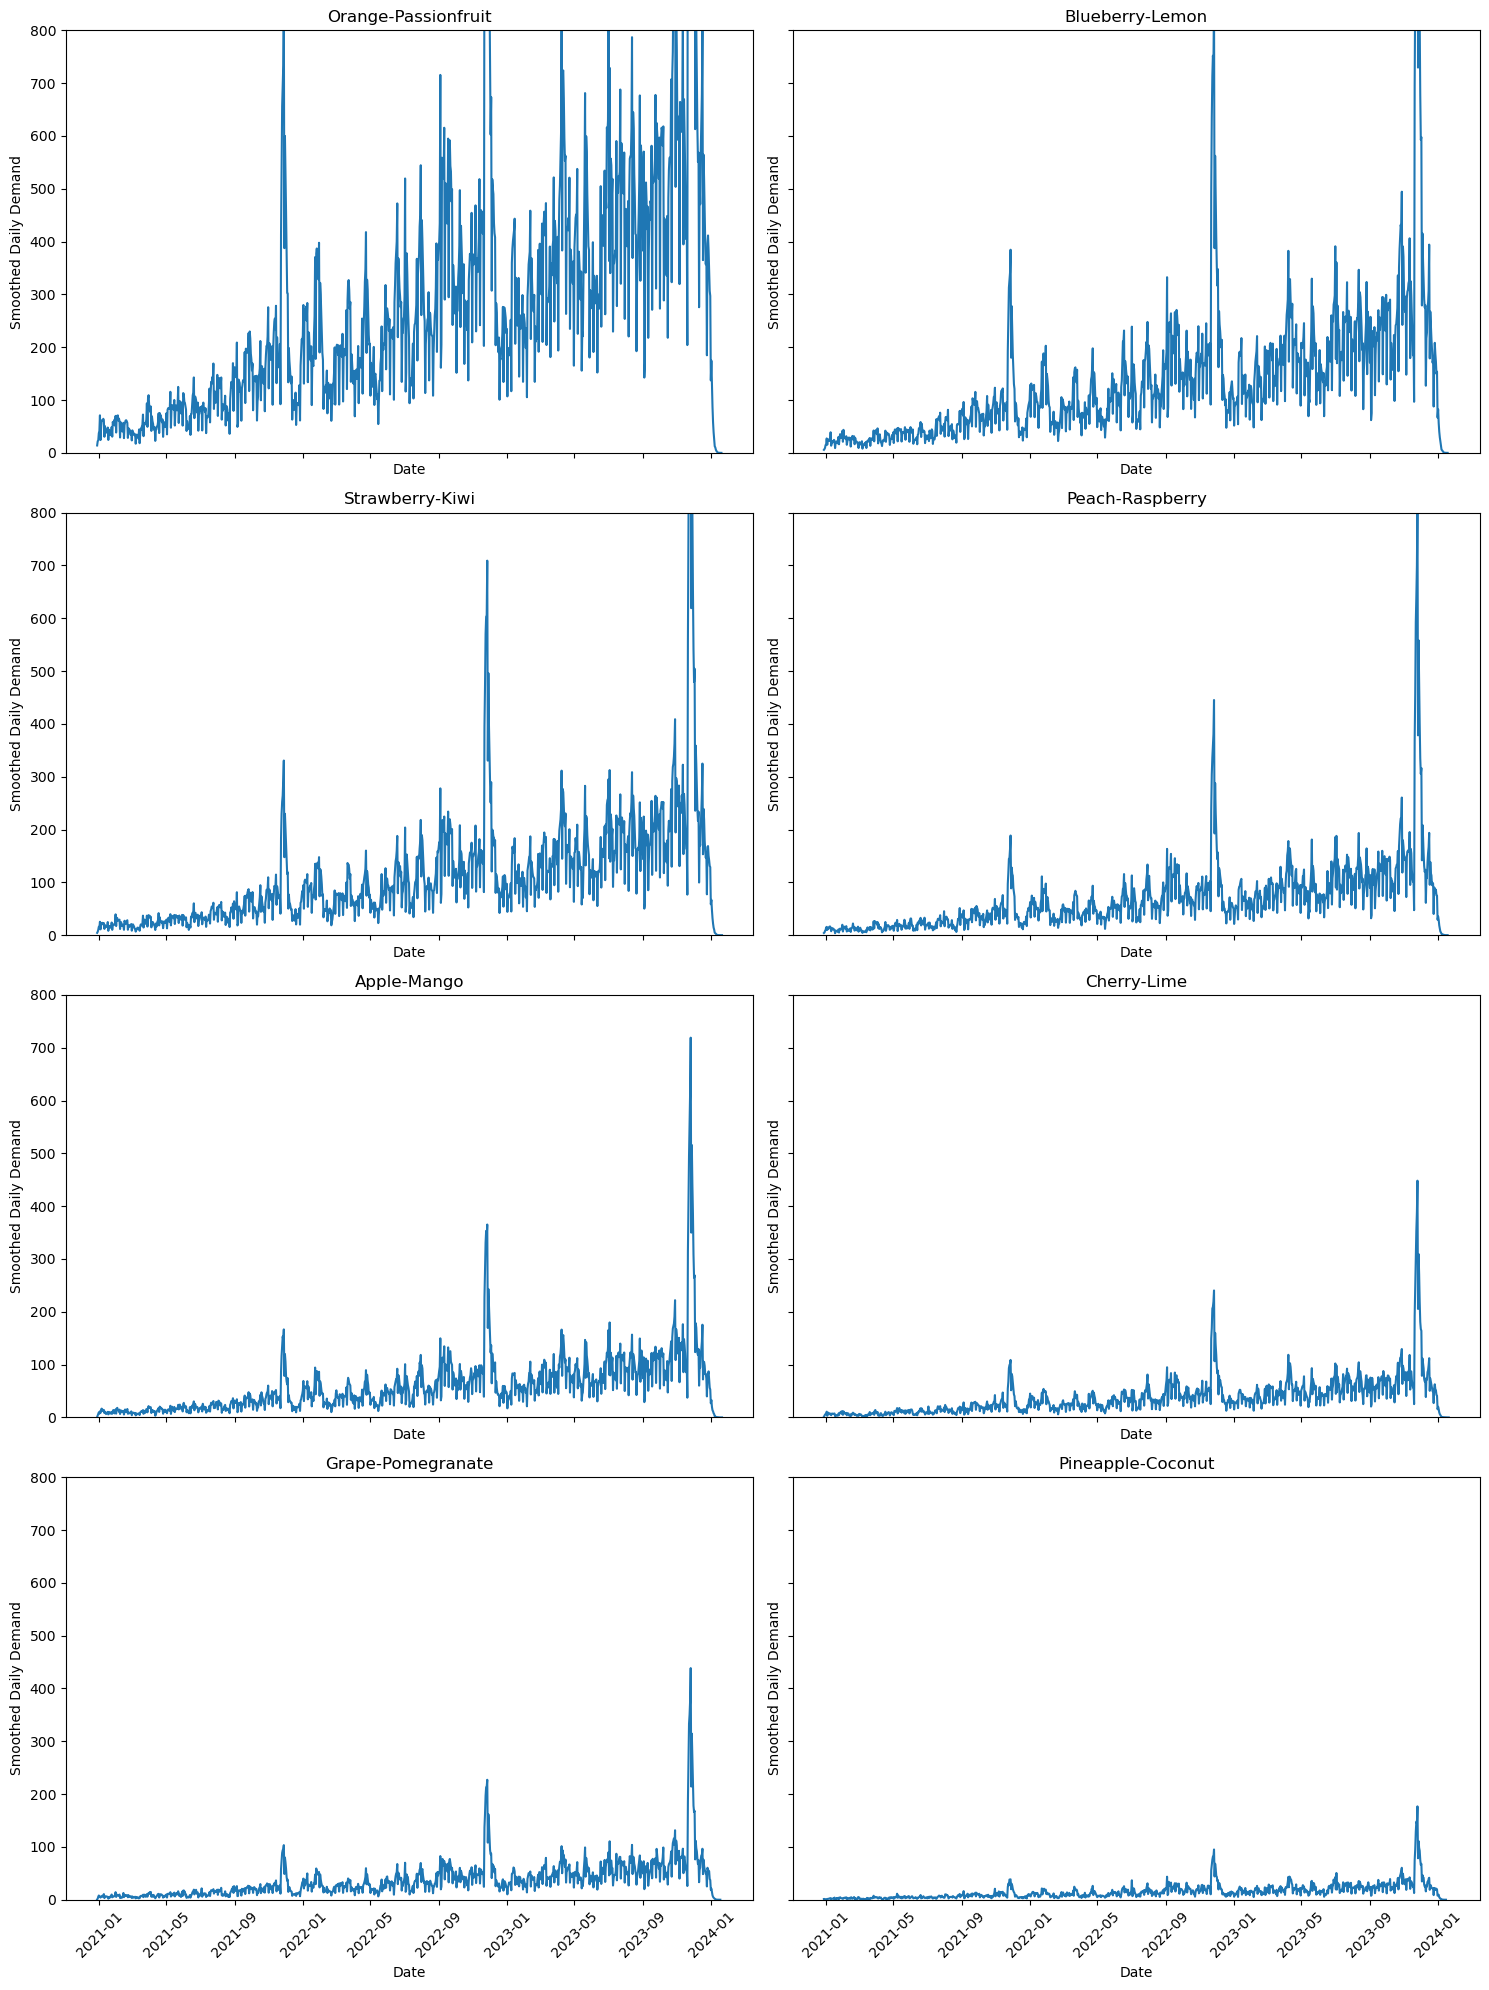

In [37]:
# Get the top 8 mixes by total smoothed daily demand
smoothed_8_mixes = final_smoothed_demand_history.groupby('Mix')['Smoothed Daily Demand'].sum().nlargest(8).index

# Filter the dataframe for only the top 8 mixes
data = final_smoothed_demand_history[final_smoothed_demand_history['Mix'].isin(smoothed_8_mixes)]

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each mix in a separate subplot
for i, mix in enumerate(smoothed_8_mixes):
    mix_data = data[data['Mix'] == mix]
    axes[i].plot(mix_data['Date'], mix_data['Smoothed Daily Demand'])
    axes[i].set_title(mix)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Smoothed Daily Demand')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylim(0, 800)  # Set y-axis range

# Adjust layout
plt.tight_layout()
plt.show()

### Understanding Order-to-Ship Times

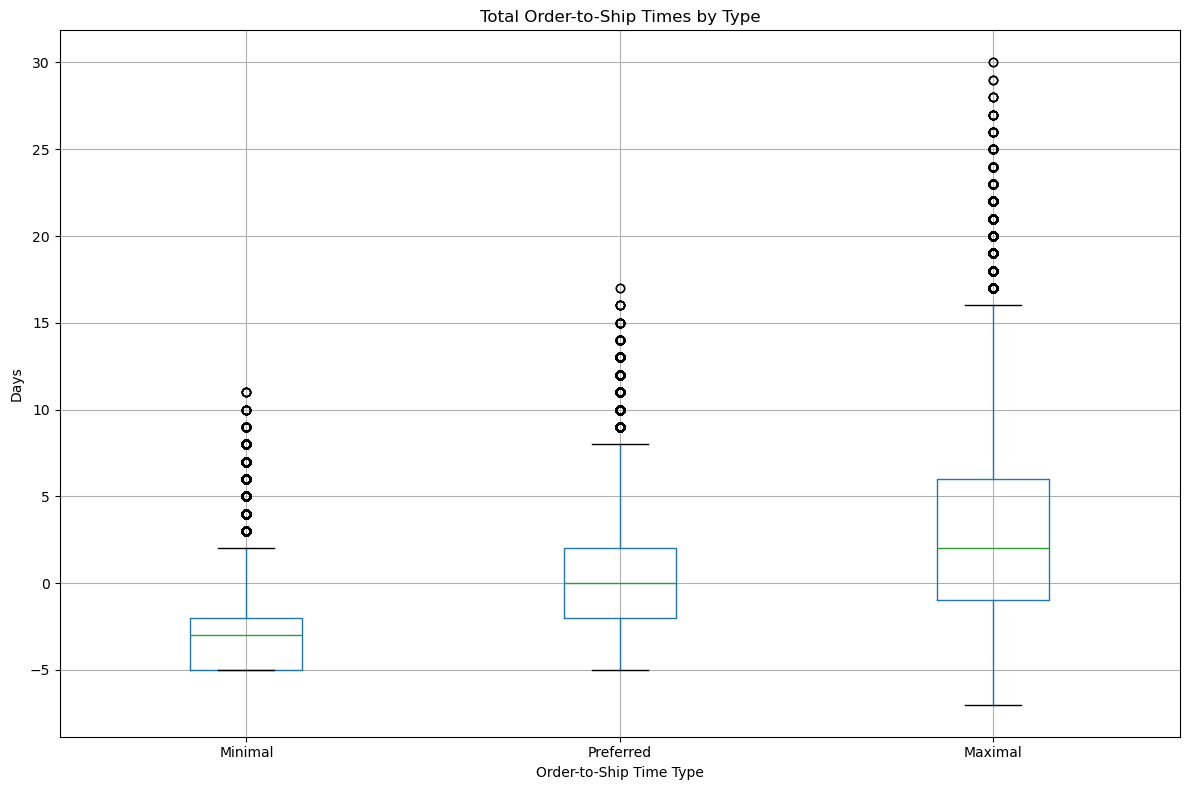

In [29]:
# Creating a boxplot for each of the specified columns in df_demand_log
plt.figure(figsize=(12, 8))

# Plot a box and whisker plot for each of the specified columns
df_demand_log.boxplot(column=['minOrderToShip', 'preferredOrderToShip', 'maxOrderToShip'])

plt.xticks([1, 2, 3], ['Minimal', 'Preferred', 'Maximal'])

plt.title('Total Order-to-Ship Times by Type')
plt.xlabel('Order-to-Ship Time Type')
plt.ylabel('Days')
plt.tight_layout()
plt.show()

According to this boxplot graph, half of the orders cannot be met on the preferred shipping date due to shipping times. The majority of the demand will have to be met between preferred and latest delivery dates.

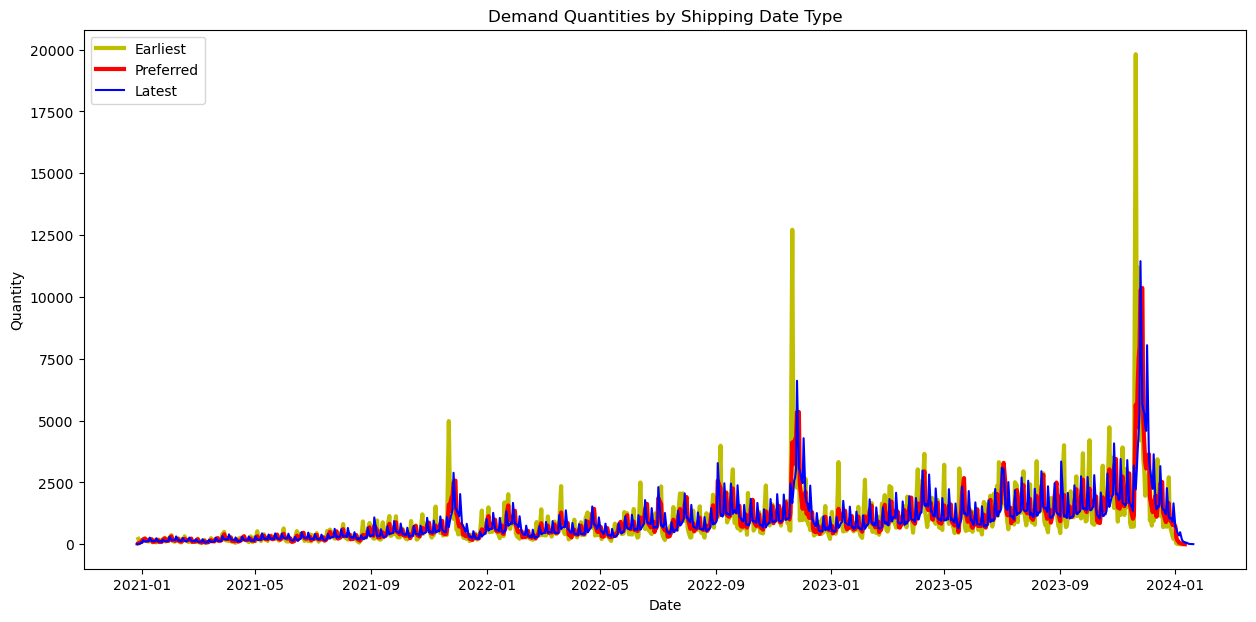

In [30]:
# Create a pivot table indexed by shipping dates
pivot_preferred_shipping_date = df_demand_log.pivot_table(index='preferredShipping', 
                                                        values='Quantity',
                                                        aggfunc='sum', 
                                                        fill_value=0)

pivot_earliest_shipping_date = df_demand_log.pivot_table(index='earliestShipping', 
                                                        values='Quantity',
                                                        aggfunc='sum', 
                                                        fill_value=0)

pivot_latest_shipping_date = df_demand_log.pivot_table(index='latestShipping', 
                                                        values='Quantity',
                                                        aggfunc='sum', 
                                                        fill_value=0)

# Plot all three pivot tables on the same graph
plt.figure(figsize=(15, 7))
plt.plot(pivot_earliest_shipping_date.index, pivot_earliest_shipping_date['Quantity'], label='Earliest', linewidth=3, color='y')
plt.plot(pivot_preferred_shipping_date.index, pivot_preferred_shipping_date['Quantity'], label='Preferred', linewidth=3, color="r")
plt.plot(pivot_latest_shipping_date.index, pivot_latest_shipping_date['Quantity'], label='Latest', linewidth=1.5, color='b')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Demand Quantities by Shipping Date Type')
plt.legend()
plt.show()

In [137]:
# The amount of demand request dates to smooth
x = 20

# This is a dataframe finding those entries where the earliest shipping date is later than the latest shipping date
df_invalid_shipping_dates = df_demand_log.iloc[invalid_shipping_dates]

# Define df_valid_shipping_dates by excluding entries in df_invalid_shipping_dates from df_demand_log
df_valid_shipping_dates = df_demand_log.drop(df_invalid_shipping_dates.index)

# Create a pivot table indexed by preferred shipping date with valid entries
pivot_smoothed_shipping = df_valid_shipping_dates.pivot_table(index='preferredShipping', values='Quantity', aggfunc='sum', fill_value=0)

pivot_smoothed_shipping = pivot_smoothed_shipping.astype({'Quantity': 'float'})

# Find the top x shipping dates with the highest quantity
top_shipping_dates = pivot_smoothed_shipping.nlargest(x, 'Quantity')

# Set the shipping dates from top_demand_dates to zero in pivot_smoothed_shipping
pivot_smoothed_shipping.loc[top_shipping_dates.index, 'Quantity'] = 0

# Iterate over the top demand dates
for date, row in top_shipping_dates.iterrows():
    
    # Filter the original dataframe for the current top demand date
    df_filtered = df_valid_shipping_dates[df_valid_shipping_dates['preferredShipping'] == date]
    
    # Iterate over the filtered dataframe
    for _, demand_row in df_filtered.iterrows():
        # Calculate the date range from earliest to latest delivery
        date_range = pd.date_range(start=demand_row['preferredShipping'], end=demand_row['latestShipping'])
        
        daily_quantity = demand_row['Quantity'] / len(date_range)
        
        # Add an entry into pivot_smoothed_demand for each date in date_range with quantity daily_quantity
        for single_date in date_range:
            if single_date in pivot_smoothed_shipping.index:
                pivot_smoothed_shipping.at[single_date, 'Quantity'] += daily_quantity
            else:
                pivot_smoothed_shipping.at[single_date, 'Quantity'] = daily_quantity

pivot_smoothed_shipping = pivot_smoothed_shipping.sort_index()

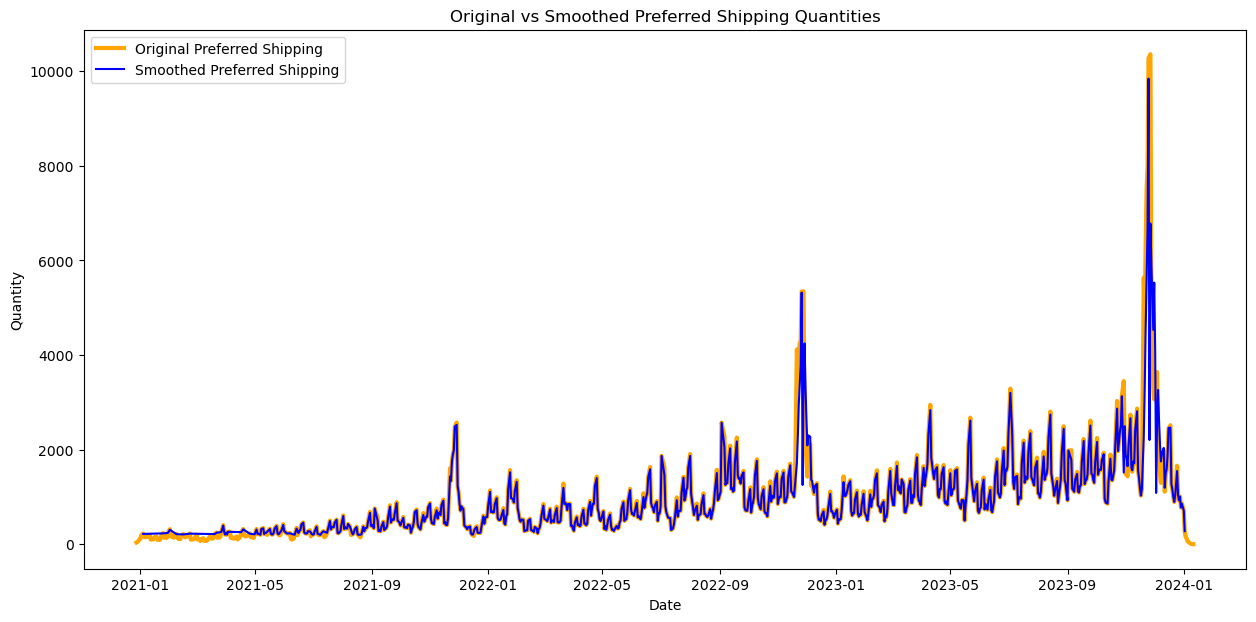

In [143]:
pivot_table_temp = df_demand_log.pivot_table(index='preferredShipping', values='Quantity', aggfunc='sum', fill_value=0)

plt.figure(figsize=(15, 7))
plt.plot(pivot_table_temp.index, pivot_table_temp['Quantity'], label='Original Preferred Shipping', linewidth=3, color='orange')
plt.plot(pivot_smoothed_shipping.index, pivot_smoothed_shipping['Quantity'], label='Smoothed Preferred Shipping', linewidth=1.5, color='blue')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Original vs Smoothed Preferred Shipping Quantities')
plt.legend()
plt.show()

In [34]:
@interact
def plot_order_to_ship_time(column=['minOrderToShip', 'preferredOrderToShip', 'maxOrderToShip']):
    plt.figure(figsize=(12, 8))
    df_demand_log.boxplot(column=column, by='Mix', figsize=(12, 8))
    if column == 'minOrderToShip':
        plt.title('Minimal Order-to-Ship Time')
    if column == 'preferredOrderToShip':
        plt.title('Preferred Order-to-Ship Time')
    if column == 'maxOrderToShip':
        plt.title('Maximal Order-to-Ship Time')
    plt.ylabel('Order-to-Ship Time')
    plt.xlabel('Mix')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='column', options=('minOrderToShip', 'preferredOrderToShip', 'maxOr…

After evaluating the demand of different product mixes a few things stand out:
First, the demand cycles do not appear consistent on a yearly basis, aside from a reliable spike in early December. The second is the demand for each product mix has grown since 2021, and with this increase in volume of demand comes an increase in the volatility of demand. Third, ship estimates are similar across all products, it does not appear certain product mixes follow different shipping patterns/timelines.

# Task 6

In [167]:
# Query where orders are impossible to fulfill
lost_demand = df_demand_log.query('maxOrderToShip < 0')
achievable_demand = df_demand_log.query('maxOrderToShip >= 0')

# Remove invalid shipping dates (latest shipping date earlier than earliest shipping date) from achievable demand
achievable_demand = achievable_demand[~achievable_demand.index.isin(invalid_shipping_dates)]

# Percentage of lost demand
lost_demand_percentage = 100 - achievable_demand['Quantity'].sum() / df_demand_log['Quantity'].sum() * 100

print(f'Percentage of lost demand: {lost_demand_percentage:.2f}%')

Percentage of lost demand: 26.50%


26.5% of the volume of demand is lost due shipping timelines where the mix that was order would have to be shipped date before the day of request, or earlier. More demand is lost due to conflicts with days not worked. Depending on the responsiveness of the supply chain, this could potentially make day of shipping or shortly after impossible as well.

# Task 7

In [168]:
production_capacity = pd.read_excel('FruitSoul Production and Materials Characteristics and Costs.xlsx', sheet_name='Center Capacity', header=2)
production_capacity.rename(columns={'Unnamed: 1': 'Center', 'Unnamed: 7': "Unit"}, inplace=True)
production_capacity.drop(columns=['Unnamed: 0'], inplace=True)

### Mixing Demand History

Because mixing demand is measured in ounces, it's demand is not exactly in line with packaging and bottling demand.

### Demand History: Ounces

In [ ]:
# Create total ounces columns
achievable_demand['ozOfProduct'] = achievable_demand['Quantity'] * achievable_demand['jarSize']

# Preferred Demand History
preferred_ounces_demand = achievable_demand.groupby(["Preferred Shipping Date"]).agg({"ozOfProduct": "sum"}).reset_index().rename(columns={"jarSize": "Ounces Demand"})

# Earliest Arrival Demand History
early_ounces_demand = achievable_demand.groupby(["Earliest Acceptable Shipping Date"]).agg({"ozOfProduct": "sum"}).reset_index().rename(columns={"jarSize": "Ounces Demand"})

# Latest Arrival Demand History
late_ounces_demand = achievable_demand.groupby(["Latest Acceptable Shipping Date"]).agg({"ozOfProduct": "sum"}).reset_index().rename(columns={"jarSize": "Ounces Demand"})

# Smoothed Arrival Demand History

def demand_probability(row, col_name='Quantity'):
    preferred_date = pd.to_datetime(row['Preferred Shipping Date'])
    earliest_date = pd.to_datetime(row['Earliest Acceptable Shipping Date'])
    latest_date = pd.to_datetime(row['Latest Acceptable Shipping Date'])
    
    # Calculate the standard deviation (earliest/latest represent ±2 standard deviations)
    std_dev = (latest_date - earliest_date).days / 4
    
    # Ensure std_dev is at least 1 to avoid division by zero
    std_dev = max(std_dev, 1)
    
    # Initialize empty list for smoothed demand distribution
    demand_distribution = []
    
    # Compute cumulative probabilities for the range of acceptable shipping dates
    for day in pd.date_range(earliest_date, latest_date):
        # CDF at the start and end of the day
        cdf_start = norm.cdf((day - pd.Timedelta(days=0.5) - preferred_date).days, scale=std_dev)
        cdf_end = norm.cdf((day + pd.Timedelta(days=0.5) - preferred_date).days, scale=std_dev)
        
        # Cumulative probability for the 24-hour period (between start and end of the day)
        daily_probability = cdf_end - cdf_start
        
        demand_distribution.append({
            'Date': day,
            'Mix': row['Mix'],
            'Probability': daily_probability
        })
    
    # Convert list to DataFrame
    df_demand_distribution = pd.DataFrame(demand_distribution)

    if len(df_demand_distribution) == 0:
        return pd.DataFrame(columns=['Date', 'Mix', 'Smoothed Daily Demand'])
    
    # Normalize probabilities to sum up to 1, then scale to match total quantity
    df_demand_distribution['smoothedDailyDemand'] = (df_demand_distribution['Probability']) * row[col_name]
    
    return df_demand_distribution[['Date', 'Mix', 'smoothedDailyDemand']]

# Apply the function to each row in the demand log and concatenate the results
smoothed_ounces_demand = pd.concat([demand_probability(row, col_name = 'ozOfProduct') for _, row in achievable_demand.iterrows()])

### Demand History: Jars

Because packaging and bottling demand is measured in jar, the demand will be identical for each order.

In [ ]:
# Preferred Demand History
preferred_jars_demand = achievable_demand.groupby(["Preferred Shipping Date"]).agg({"Quantity": "sum"}).reset_index().rename(columns={"jarSize": "Jars Demand"})
# Earliest Arrival Demand History
early_jars_demand = achievable_demand.groupby(["Earliest Acceptable Shipping Date"]).agg({"Quantity": "sum"}).reset_index().rename(columns={"jarSize": "Jars Demand"})
# Latest Arrival Demand History
late_jars_demand = achievable_demand.groupby(["Latest Acceptable Shipping Date"]).agg({"Quantity": "sum"}).reset_index().rename(columns={"jarSize": "Jars Demand"})

# Smoothed Arrival Demand History
smoothed_jars_demand = pd.concat([demand_probability(row, col_name = 'Quantity') for _, row in achievable_demand.iterrows()])

### Adjust demand dates for off days

In [ ]:
# Adjust the dates
smoothed_jars_demand['Date'] = smoothed_jars_demand['Date'].apply(lambda x: adjust_date(x, 'e'))
smoothed_ounces_demand['Date'] = smoothed_ounces_demand['Date'].apply(lambda x: adjust_date(x, 'e'))

# Apply the function to the Preferred Shipping Date column
smoothed_jars_demand['Date'] = smoothed_jars_demand['Date'].apply(adjust_preferred_shipping_date)
smoothed_ounces_demand['Date'] = smoothed_ounces_demand['Date'].apply(adjust_preferred_shipping_date)

In [ ]:
smoothed_jars_demand_date = smoothed_jars_demand.groupby('Date').agg({'smoothedDailyDemand': 'sum'}).reset_index()
smoothed_ounces_demand_date = smoothed_ounces_demand.groupby('Date').agg({'smoothedDailyDemand': 'sum'}).reset_index()

# Task 8

### Identify production capacity 

In [ ]:
def identify_production_demand(demand_vector, s = 5):
    s_pctile_demand  = np.percentile(np.array(demand_vector), 100-s)
    return s_pctile_demand

def identify_max_daily_production(production_capacity, center_name = "Mixing"):
    max_shift_production = production_capacity[production_capacity['Center'] == center_name][5].values[0]
    max_daily_production = max_shift_production * 2
    return max_daily_production

def identify_cells_needed(demand, max_daily_production):
    cells_needed = np.ceil(demand / max_daily_production)
    return cells_needed

In [ ]:
jars = smoothed_jars_demand_date.rename(columns={'smoothedDailyDemand': 'jarsDemand'})
ounces = smoothed_ounces_demand_date.rename(columns={'smoothedDailyDemand': 'ouncesDemand'})

# Merge on Date
production_demand = jars.merge(ounces, on='Date', how='left')

# Fill NA values with 0\
production_demand.fillna(0, inplace=True)

### Identify total cells needed

In [ ]:
def identify_total_cells_needed(production_demand, production_capacity, center_name, s):
    unit = production_capacity[production_capacity['Center'] == center_name]['Unit'].values[0]
    if unit == "Jars":
        demand_vector = production_demand['jarsDemand']
    else:
        demand_vector = production_demand['ouncesDemand']
    s_pctile_demand = identify_production_demand(demand_vector, s)
    max_daily_production = identify_max_daily_production(production_capacity, center_name)
    cells_needed = identify_cells_needed(s_pctile_demand, max_daily_production)
    return cells_needed

identify_total_cells_needed(production_demand['smoothedDailyDemand'], production_capacity, "Mixing", 5)

### Optimize Daily Set-Up

In [ ]:
# Create function to return demand for a given date
def get_demand(date, unit, production_demand, demandColumnName = 'smoothedDailyDemand'):
    return production_demand[(production_demand['Date'] == date) & (production_demand['Unit'] == unit)][demandColumnName].values[0]

In [ ]:
# Ensure achievable_demand_temp is defined
achievable_demand_temp = achievable_demand.copy()
achievable_demand_temp.insert(achievable_demand_temp.columns.get_loc('Quantity') + 1, 'ozOfProduct', achievable_demand_temp['jarSize'] * achievable_demand_temp['Quantity'])

# Create a pivot table indexed by preferredShipping date with columns Quantity and ozOfProduct
pivot_preferred_shipping = achievable_demand_temp.pivot_table(
    index='preferredShipping',
    values=['Quantity'],
    aggfunc='sum'
)

In [149]:
achievable_demand_temp

,DemandID,demandRequest,Mix,jarSize,State,Quantity,ozOfProduct,earliestDelivery,preferredDelivery,latestDelivery,earliestShipping,preferredShipping,latestShipping,minOrderToShip,preferredOrderToShip,maxOrderToShip
0,1,2021-01-01,Apple-Mango,8,Maryland,1,8,2021-01-01,2021-01-04,2021-01-07,2020-12-28,2020-12-30,2021-01-02,-4,-2,1
1,2,2021-01-01,Blueberry-Lemon,32,Kentucky,1,32,2021-01-04,2021-01-06,2021-01-09,2021-01-01,2021-01-04,2021-01-06,0,3,5
2,3,2021-01-01,Orange-Passionfruit,16,Minnesota,1,16,2021-01-07,2021-01-10,2021-01-11,2021-01-02,2021-01-05,2021-01-06,1,4,5
3,4,2021-01-01,Orange-Passionfruit,16,California,1,16,2021-01-07,2021-01-11,2021-01-14,2021-01-02,2021-01-06,2021-01-09,1,5,8
4,5,2021-01-01,Orange-Passionfruit,32,Louisiana,1,32,2021-01-01,2021-01-04,2021-01-10,2020-12-28,2020-12-31,2021-01-06,-4,-1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835369,835370,2023-12-31,Apple-Mango,32,Kentucky,1,32,2023-12-31,2024-01-04,2024-01-04,2023-12-28,2024-01-01,2024-01-01,-3,1,1
835370,835371,2023-12-31,Strawberry-Kiwi,32,Indiana,1,32,2023-12-31,2024-01-05,2024-01-05,2023-12-28,2024-01-02,2024-01-02,-3,2,2
835371,835372,2023-12-31,Blueberry-Lemon,32,New York,1,32,2023-12-31,2024-01-07,2024-01-07,2023-12-26,2024-01-02,2024-01-02,-5,2,2
835373,835374,2023-12-31,Peach-Raspberry,16,New York,1,16,2024-01-03,2024-01-03,2024-01-09,2023-12-29,2023-12-29,2024-01-04,-2,-2,4


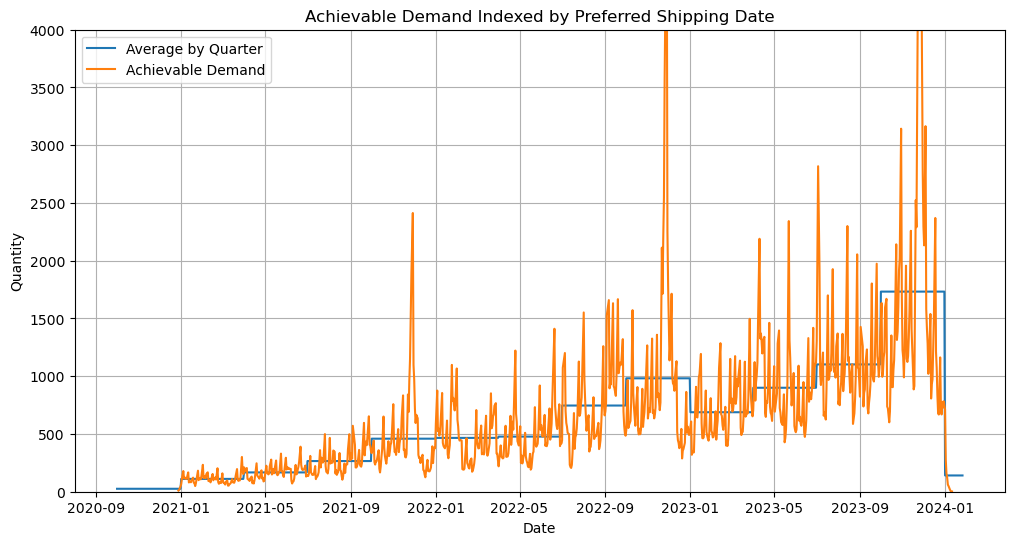

In [151]:
# Resample the pivot_preferred_shipping to monthly frequency and calculate the mean
quarterly_average_preferred_shipping = pivot_preferred_shipping.resample('YE').mean()

# Refine average quantity by quarter to make a proper line plot
for i in quarterly_average_preferred_shipping.index:
    three_months_prior = (i - pd.DateOffset(months=2)).month
    year_month = pd.to_datetime(f'{i.year}-{three_months_prior}-01')
    new_row = pd.DataFrame({'Quantity': [quarterly_average_preferred_shipping.loc[i, 'Quantity']]}, index=[year_month])
    quarterly_average_preferred_shipping = pd.concat([quarterly_average_preferred_shipping, new_row]).sort_index()

quarterly_average_preferred_shipping.index = quarterly_average_preferred_shipping.index[:-1].append(pd.to_datetime([last_day]))

plt.figure(figsize=(12, 6))

plt.plot(quarterly_average_preferred_shipping.index, quarterly_average_preferred_shipping['Quantity'], label='Average by Quarter')

# Plot achievable demand indexed by preferred shipping date with quantity
plt.plot(pivot_preferred_shipping.index, pivot_preferred_shipping['Quantity'], label='Achievable Demand')

plt.title('Achievable Demand Indexed by Preferred Shipping Date')
plt.xlabel('Date')
plt.ylabel('Quantity')

plt.ylim(0, 4000)

plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Reindex achievable_demand_temp by preferred shipping date
achievable_demand_temp.set_index('preferredShipping', inplace=True)

In [158]:
# Sort achievable_demand_temp by preferredShipping, then by maxOrderToShip
achievable_demand_temp = achievable_demand_temp.sort_values(by=['preferredShipping', 'maxOrderToShip'])
achievable_demand_temp

,DemandID,demandRequest,Mix,jarSize,State,Quantity,ozOfProduct,earliestDelivery,preferredDelivery,latestDelivery,earliestShipping,latestShipping,minOrderToShip,preferredOrderToShip,maxOrderToShip
preferredShipping,,,,,,,,,,,,,,,
2020-12-28,436,2021-01-02,Orange-Passionfruit,16,New York,1,16,2021-01-02,2021-01-02,2021-01-08,2020-12-28,2021-01-02,-5,-5,0
2020-12-28,386,2021-01-02,Orange-Passionfruit,32,Wisconsin,1,32,2021-01-02,2021-01-02,2021-01-08,2020-12-28,2021-01-02,-5,-5,0
2020-12-28,67,2021-01-01,Orange-Passionfruit,32,New York,1,32,2021-01-01,2021-01-02,2021-01-06,2020-12-28,2021-01-01,-4,-4,0
2020-12-28,112,2021-01-02,Blueberry-Lemon,8,New York,1,8,2021-01-02,2021-01-02,2021-01-08,2020-12-28,2021-01-02,-5,-5,0
2020-12-28,51,2021-01-01,Pineapple-Coconut,32,New York,1,32,2021-01-01,2021-01-02,2021-01-07,2020-12-28,2021-01-02,-4,-4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-09,831896,2023-12-29,Apple-Mango,16,California,1,16,2024-01-09,2024-01-14,2024-01-26,2024-01-04,2024-01-20,6,11,22
2024-01-10,832321,2023-12-29,Orange-Passionfruit,32,South Dakota,1,32,2024-01-06,2024-01-12,2024-01-19,2024-01-04,2024-01-17,6,12,19
2024-01-10,831263,2023-12-28,Cherry-Lime,8,Kentucky,1,8,2024-01-09,2024-01-13,2024-01-23,2024-01-06,2024-01-20,9,13,23


In [159]:
# Select only the columns maxOrderToShip, Quantity, and ozOfProduct from achievable_demand_temp
achievable_demand_temp = achievable_demand_temp[['maxOrderToShip', 'Quantity', 'ozOfProduct']]
achievable_demand_temp.head()

,maxOrderToShip,Quantity,ozOfProduct
preferredShipping,,,
2020-12-28,0,1,16
2020-12-28,0,1,32
2020-12-28,0,1,32
2020-12-28,0,1,8
2020-12-28,1,1,32


In [162]:
# Aggregate the quantity and ozOfProduct for each unique maxOrderToShip for each preferredShipping date
aggregated_data = achievable_demand_temp.groupby(['preferredShipping', 'maxOrderToShip']).agg({
    'Quantity': 'sum',
    'ozOfProduct': 'sum'
}).reset_index()

aggregated_data

,preferredShipping,maxOrderToShip,Quantity,ozOfProduct
0,2020-12-28,0,4,88
1,2020-12-28,1,1,32
2,2020-12-28,2,1,8
3,2020-12-28,3,1,32
4,2020-12-28,7,2,40
...,...,...,...,...
18265,2024-01-09,20,1,8
18266,2024-01-09,22,1,16
18267,2024-01-10,19,1,32
18268,2024-01-10,23,1,8


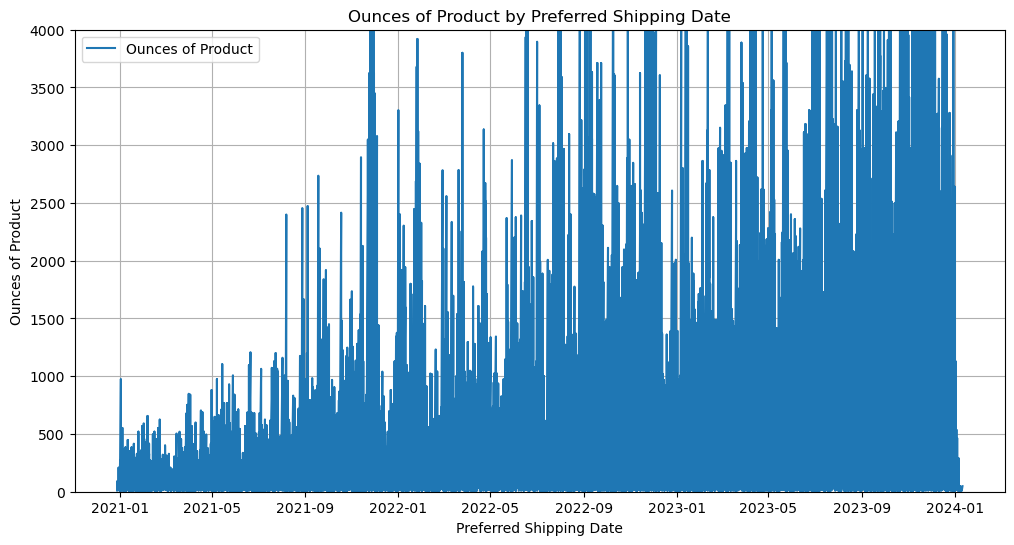

In [165]:
plt.figure(figsize=(12, 6))
plt.plot(aggregated_data['preferredShipping'], aggregated_data['ozOfProduct'], label='Ounces of Product')
plt.xlabel('Preferred Shipping Date')
plt.ylabel('Ounces of Product')
plt.ylim(0, 4000)
plt.title('Ounces of Product by Preferred Shipping Date')
plt.legend()
plt.grid(True)
plt.show()

# Task 9

# Task 10

Each tier of shelving would be 96in x 36in x 12in, with only enough room for one layer of each box to account for handling.

8oz jar cases are 13in x 10in. If they are stored with the long face on the long side of shelving, then 21 cases can fit on a shelf.

16oz jar cases are 15in x 10in. Either way, 18 cases can be stored on a shelf.

32oz jar cases are 17in x 13in. If the short face is on the long face of the shelving, then 14 cases can fit on a shelf.

In [11]:
num_of_8oz_cases = 200
num_of_16oz_cases = 100
num_of_32oz_cases = 50

def number_of_tiers_for_cases(num_cases, size):
    if size == 8:
        return math.ceil(num_cases / 21)
    if size == 16:
        return math.ceil(num_cases / 18)
    if size == 32:
        return math.ceil(num_cases / 15)
    return

print(f"Number of 8 oz jar tiers needed: {number_of_tiers_for_cases(num_of_8oz_cases, 8)}")
print(f"Number of 16 oz jar tiers needed: {number_of_tiers_for_cases(num_of_16oz_cases, 16)}")
print(f"Number of 32 oz jar tiers needed: {number_of_tiers_for_cases(num_of_32oz_cases, 32)}")

Number of 8 oz jar tiers needed: 10
Number of 16 oz jar tiers needed: 6
Number of 32 oz jar tiers needed: 4


# Task 11

Practice A) All finished bottles go to FPDC to be stored first, then FIFO from FPDC.

The benefit of this practice is the first product in will always be used first, so there is no product sitting for a long time. A downside is there is more double handling for each product. 

Practice B) If finished botteles are needed for packaging in next H hours (2-4 hours, currently), then go first to packaging. All else goes to FPDC to be stored and used with FIFO.

This allows for less double handling of product and, if the bottling and packaging centers are close, less empty-handed travel time on the way back from packaging. Making sure the rest of the product uses FIFO may not be a concern if product moves fast enough, but if not then there would more hands on managing. 

Maybe a mix of both would work. If there are many orders, then practice B could be utilized to save time, but when things are slow practice A could insure FIFO is being adhered to.

# Task 12

# Task 13

Mix containers are 12in x 12in, meaning a shelf 96in x 36in wide can hold up to 24 mix containers of a certain mix.

In [15]:
num_oz_apple_mango = 1500
num_oz_blackberry_pear = 500
num_oz_blueberry_lemon = 300
num_oz_cherry_lime = 2000
num_oz_grape_pomegranate = 1000
num_oz_orange_passionfruit = 15000
num_oz_peach_raspberry = 5000
num_oz_pineapple_coconut = 350
num_oz_strawberry_kiwi = 450

def number_of_tiers_for_oz(num_oz):
    gallons_needed = num_oz / 128
    containers_needed = gallons_needed / 3
    tiers_needed = containers_needed / 24
    return math.ceil(tiers_needed)

print(f"Number of tiers needed for {num_oz_apple_mango} oz of Apple Mango: {number_of_tiers_for_oz(num_oz_apple_mango)}")
print(f"Number of tiers needed for {num_oz_blackberry_pear} oz of Blackberry Pear: {number_of_tiers_for_oz(num_oz_blackberry_pear)}")
print(f"Number of tiers needed for {num_oz_blueberry_lemon} oz of Blueberry Lemon: {number_of_tiers_for_oz(num_oz_blueberry_lemon)}")
print(f"Number of tiers needed for {num_oz_cherry_lime} oz of Cherry Lime: {number_of_tiers_for_oz(num_oz_cherry_lime)}")
print(f"Number of tiers needed for {num_oz_grape_pomegranate} oz of Grape Pomegranate: {number_of_tiers_for_oz(num_oz_grape_pomegranate)}")
print(f"Number of tiers needed for {num_oz_orange_passionfruit} oz of Orange Passionfruit: {number_of_tiers_for_oz(num_oz_orange_passionfruit)}")
print(f"Number of tiers needed for {num_oz_peach_raspberry} oz of Peach Raspberry: {number_of_tiers_for_oz(num_oz_peach_raspberry)}")
print(f"Number of tiers needed for {num_oz_pineapple_coconut} oz of Pineapple Coconut: {number_of_tiers_for_oz(num_oz_pineapple_coconut)}")
print(f"Number of tiers needed for {num_oz_strawberry_kiwi} oz of Strawberry Kiwi: {number_of_tiers_for_oz(num_oz_strawberry_kiwi)}")


Number of tiers needed for 1500 oz of Apple Mango: 1
Number of tiers needed for 500 oz of Blackberry Pear: 1
Number of tiers needed for 300 oz of Blueberry Lemon: 1
Number of tiers needed for 2000 oz of Cherry Lime: 1
Number of tiers needed for 1000 oz of Grape Pomegranate: 1
Number of tiers needed for 15000 oz of Orange Passionfruit: 2
Number of tiers needed for 5000 oz of Peach Raspberry: 1
Number of tiers needed for 350 oz of Pineapple Coconut: 1
Number of tiers needed for 450 oz of Strawberry Kiwi: 1


# Task 14

As long as there is enough demand in a day, then bringing newly made mixes straight to bottling shouldn't affect FIFO adherence and will save time from double handling. The main issue is that an order doesn't necessarily use all of the output from the mixing processing center. It produces 3 gallon containers, which can supply the mix for many small orders. If newer product was sent directly to bottling, on less demanding days there could be older product not being used up.

Once again, probably a mixed approach would work best. On fast days, use direct mixing center output to bottling center input to save time, but if things are going slow, then sending mix output to Mix DC would make sure FIFO is used.